<a href="https://colab.research.google.com/github/lucaspaulo1/TP-Introducao-ciencia-dados/blob/main/analises_finais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidade Federal de Minas Gerais
# Trabalho Prático - Introdução à Ciência dos Dados

# Integrantes - Grupo 12

Eduardo Alves Cordeiro <br>
Lucas Paulo de Oliveira Silva <br>
Wesley Marques Daniel Chaves <br>
Victor Henrique Silva Ribeiro

# Perguntas - Tema: Violência

- Existe uma relação entre a intensidade do extrativismo e agropecuária e a quantidade de desmatamento no Brasil?<br>
- Existe uma correlação significativa entre a quantidade de homicídios nos municípios de MG e seus indicadores socioeconômicos?<br>
- Existe uma relação entre a quantidade de posse ilegal de armas de fogo e a quantidade de roubos ou furtos de veículos no Brasil?<br>
- O aumento da posse e porte de armas está relacionado ao crescimento dos índices de feminicídio e violência contra a mulher?

# Relatório - Análise entre homicícios e indicadores socioeconômicos dos municípios de Minas Gerais
#### Autor: Wesley Marques Daniel Chaves

## Introdução

A taxa de homicídios é um fenômeno complexo que pode estar influenciado por diversos fatores. Neste estudo, iremos investigar se há correlações entre a quantidade de homicídios e variáveis como população, densidade demográfica, IDHM, PIB per capita e escolarização.

**Pergunta de pesquisa**: Existe uma correlação significativa entre a quantidade de homicídios nos municípios de MG e seus indicadores socioeconômicos?

## Metodologia

A análise será baseada em duas principais fontes de dados:

  **Dados Socioeconômicos**: Esses dados foram obtidos do Instituto Brasileiro de Geografia e Estatística (IBGE) e incluem informações de 853 municípios, como população residente, densidade demográfica, escolarização, IDHM, mortalidade infantil, receitas e despesas municipais, e PIB per capita.

  **Ocorrências Criminais**: A base de homicídios foi obtida no site da Secretaria de Estado de Justiça e Segurança Pública de Minas Gerais (SEJUSP). Esta base contém 40.976 registros de ocorrências criminais, com detalhes como o município do crime, data, horário, meio utilizado, e características das vítimas e autores.

## Métodos e Modelos

**Limpeza de Dados**: Incluiu a remoção de variáveis irrelevantes, renomeação de variáveis e tratamento de valores ausentes.

**Análise Exploratória**: Consistiu em verificar correlações entre as variáveis, criar histogramas e heatmaps para visualização, e realizar testes de hipótese via bootstrap para comparar homicídios em municípios com diferentes níveis de escolarização/IDHM.

**Modelos**: Foram utilizados os modelos de regressão linear, árvore de decisão e random forest, avaliados por validação cruzada com as métricas MSE e R², uso de bootstrap para intervalos de confiança das métricas, além de análise da importância das variáveis para cada modelo.

## Código

### Limpeza dos dados

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
socio_df_raw = pd.read_csv("/content/drive/My Drive/socio_dataset.csv")
homicidio_df_raw = pd.read_csv("/content/drive/My Drive/homicidios_MG.csv")

In [ ]:
socio_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 13 columns):
 #   Column                                                               Non-Null Count  Dtype 
---  ------                                                               --------------  ----- 
 0   Município [-]                                                        853 non-null    object
 1   Código [-]                                                           853 non-null    int64 
 2   Gentílico [-]                                                        853 non-null    object
 3   Prefeito [2021]                                                      853 non-null    object
 4   Área Territorial - km² [2022]                                        853 non-null    object
 5   População residente - pessoas [2022]                                 853 non-null    int64 
 6   Densidade demográfica - hab/km² [2022]                               853 non-null    object
 7   Escolarização <sp

In [ ]:
# seleciona colunas desejadas
socio_df = socio_df_raw.copy()[['Município [-]',
                                'Código [-]',
                                'População residente - pessoas [2022]',
                                'Densidade demográfica - hab/km² [2022]',
                                'Escolarização <span>6 a 14 anos</span> - % [2010]',
                                'IDHM <span>Índice de desenvolvimento humano municipal</span> [2010]',
                                'PIB per capita - R$ [2021]']]

# renomeia colunas
socio_df.rename(columns={'Município [-]': 'municipio',
                         'Código [-]': 'codigo',
                         'População residente - pessoas [2022]': 'populacao',
                         'Densidade demográfica - hab/km² [2022]': 'densidade_demografica',
                         'Escolarização <span>6 a 14 anos</span> - % [2010]': 'escolarizacao',
                         'IDHM <span>Índice de desenvolvimento humano municipal</span> [2010]': 'idhm',
                         'PIB per capita - R$ [2021]': 'pib_per_capita'}, inplace=True)
socio_df.head(1)

,municipio,codigo,populacao,densidade_demografica,escolarizacao,idhm,pib_per_capita
0,Abadia dos Dourados,3100104,6272,"7,12","98,3","0,689","25174,26"


In [ ]:
homicidio_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40976 entries, 0 to 40975
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Número REDS                      40976 non-null  object
 1   Número Envolvido/Ocorrência      40976 non-null  int64 
 2   Natureza Principal Final         40976 non-null  object
 3   Ano Fato                         40976 non-null  int64 
 4   Mês Fato Resumido                40976 non-null  object
 5   Mês Numérico Fato                40976 non-null  int64 
 6   Data Fato                        40976 non-null  object
 7   Dia da Semana Fato               40976 non-null  object
 8   Horário Fato                     40976 non-null  object
 9   Faixa 1 Hora Fato                40976 non-null  object
 10  Faixa 6 Horas Fato               40976 non-null  object
 11  Causa Presumida                  40976 non-null  object
 12  Desc Longa Meio Utilizado       

In [ ]:
# seleciona coluna desejada
homicidio_df = homicidio_df_raw.copy()[['Município - Código - FATO']]

# renomeia coluna
homicidio_df.rename(columns={'Município - Código - FATO': 'codigo'}, inplace=True)

# insere coluna quantidade_homicídios
homicidio_df = homicidio_df.groupby('codigo').size().reset_index(name='quantidade_homicidios')
homicidio_df.head(1)

,codigo,quantidade_homicidios
0,310010,9


In [ ]:
# retira ultimo dígito (adicional) do codigo em socio_df
socio_df['codigo'] = socio_df['codigo'] / 10
socio_df['codigo'] = socio_df['codigo'].astype(int)
socio_df.head(1)

,municipio,codigo,populacao,densidade_demografica,escolarizacao,idhm,pib_per_capita
0,Abadia dos Dourados,310010,6272,"7,12","98,3","0,689","25174,26"


In [ ]:
# contrói dataframe completo
complete_df = socio_df.copy()
complete_df = complete_df.merge(homicidio_df, on=['codigo'])
complete_df.head(1)

,municipio,codigo,populacao,densidade_demografica,escolarizacao,idhm,pib_per_capita,quantidade_homicidios
0,Abadia dos Dourados,310010,6272,"7,12","98,3","0,689","25174,26",9


In [ ]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   municipio              818 non-null    object
 1   codigo                 818 non-null    int64 
 2   populacao              818 non-null    int64 
 3   densidade_demografica  818 non-null    object
 4   escolarizacao          818 non-null    object
 5   idhm                   818 non-null    object
 6   pib_per_capita         818 non-null    object
 7   quantidade_homicidios  818 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 51.2+ KB


In [ ]:
# converte todas as colunas 'object' de interesse em numérico
cols_to_convert = ['densidade_demografica', 'escolarizacao', 'idhm', 'pib_per_capita']
for col in cols_to_convert:
    complete_df[col] = complete_df[col].str.replace(',', '.').astype(float)
complete_df[cols_to_convert] = complete_df[cols_to_convert].astype(float)
complete_df.head(1)

,municipio,codigo,populacao,densidade_demografica,escolarizacao,idhm,pib_per_capita,quantidade_homicidios
0,Abadia dos Dourados,310010,6272,7.12,98.3,0.689,25174.26,9


In [ ]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   municipio              818 non-null    object 
 1   codigo                 818 non-null    int64  
 2   populacao              818 non-null    int64  
 3   densidade_demografica  818 non-null    float64
 4   escolarizacao          818 non-null    float64
 5   idhm                   818 non-null    float64
 6   pib_per_capita         818 non-null    float64
 7   quantidade_homicidios  818 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 51.2+ KB


### Análise exploratória

In [ ]:
complete_df.describe()

,codigo,populacao,densidade_demografica,escolarizacao,idhm,pib_per_capita,quantidade_homicidios
count,818.000000,8.180000e+02,818.000000,818.000000,818.000000,818.000000,818.000000
mean,313673.309291,2.497501e+04,71.154010,97.430196,0.667738,31191.401161,50.092910
std,2070.111366,9.625058e+04,320.916284,1.681356,0.050367,55426.758161,243.783275
min,310010.000000,1.081000e+03,1.210000,83.900000,0.529000,6983.080000,1.000000
25%,311912.500000,4.840250e+03,12.222500,96.700000,0.632000,14152.070000,5.000000
50%,313697.500000,8.469500e+03,22.405000,97.700000,0.670000,19769.390000,11.000000
75%,315448.750000,1.778525e+04,44.477500,98.500000,0.703000,30438.675000,29.000000
max,317220.000000,2.315560e+06,6988.180000,100.000000,0.813000,920833.970000,5698.000000


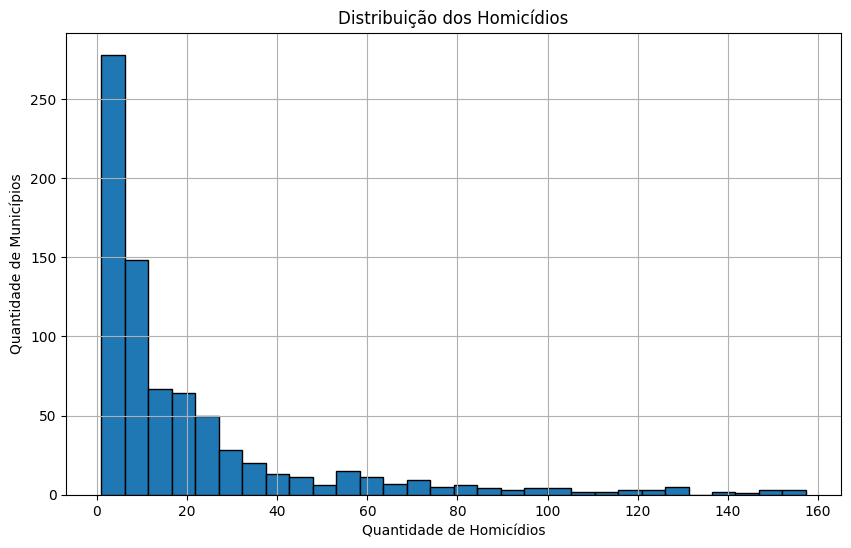

In [ ]:
min_value = complete_df['quantidade_homicidios'].min()
max_value = complete_df['quantidade_homicidios'].quantile(0.95)

plt.figure(figsize=(10, 6))
plt.hist(complete_df['quantidade_homicidios'], bins=30, range=(min_value, max_value), edgecolor='black')
plt.title('Distribuição dos Homicídios')
plt.xlabel('Quantidade de Homicídios')
plt.ylabel('Quantidade de Municípios')
plt.grid(True)
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix

# obtém correlações entre as variáveis e quantidade_homicídios
copy = complete_df.copy()[['populacao', 'densidade_demografica', 'escolarizacao', 'idhm', 'pib_per_capita', 'quantidade_homicidios']]
corr_matrix = copy.corr()
corr_matrix['quantidade_homicidios'].sort_values(ascending=False)

,quantidade_homicidios
quantidade_homicidios,1.000000
populacao,0.960602
densidade_demografica,0.873608
idhm,0.235131
pib_per_capita,0.034372
escolarizacao,0.008241


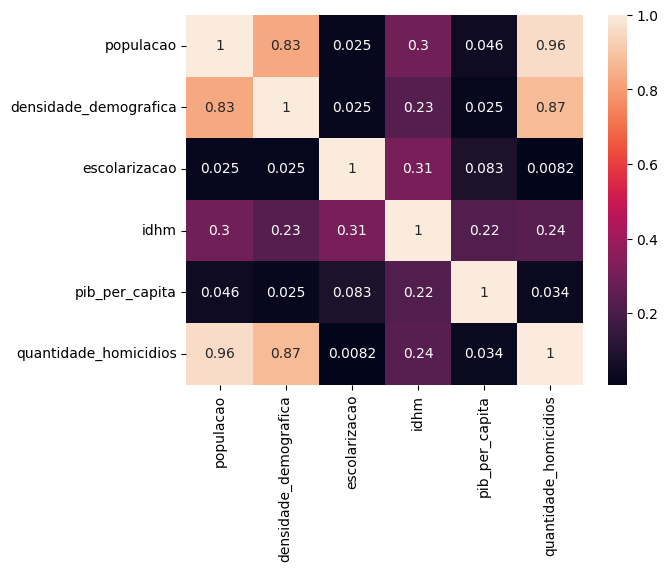

In [ ]:
sns.heatmap(complete_df[['populacao', 'densidade_demografica', 'escolarizacao', 'idhm', 'pib_per_capita', 'quantidade_homicidios']].corr(), annot=True)
plt.show()

In [ ]:
import numpy as np
def bootstrap_mean_diff(group1, group2, num_samples=1000, ci=95):
    mean_diffs = []
    n1, n2 = len(group1), len(group2)
    for _ in range(num_samples):
        sample1 = np.random.choice(group1, n1, replace=True)
        sample2 = np.random.choice(group2, n2, replace=True)
        mean_diffs.append(np.mean(sample1) - np.mean(sample2))
    lower_bound = np.percentile(mean_diffs, (100-ci)/2)
    upper_bound = np.percentile(mean_diffs, 100-(100-ci)/2)
    return mean_diffs, lower_bound, upper_bound

**Hipótese Nula:** Não há diferença na média de homicídios entre municípios com alta e baixa escolarização.

**Hipótese Alternativa:** Há uma diferença significativa na média de homicídios entre municípios com alta e baixa escolarização.

In [ ]:
media_escolarizacao = complete_df['escolarizacao'].mean()

alta_escolarizacao = complete_df[complete_df['escolarizacao'] > media_escolarizacao]['quantidade_homicidios']
baixa_escolarizacao = complete_df[complete_df['escolarizacao'] <= media_escolarizacao]['quantidade_homicidios']

In [ ]:
mean_diffs, lower_diff, upper_diff = bootstrap_mean_diff(alta_escolarizacao, baixa_escolarizacao)
print(f"Média das Diferenças de Médias: {np.mean(mean_diffs)}")
print(f"Intervalo de Confiança: [{lower_diff}, {upper_diff}]")

Média das Diferenças de Médias: 4.531758689892742
Intervalo de Confiança: [-23.090818939407846, 35.56636349174298]


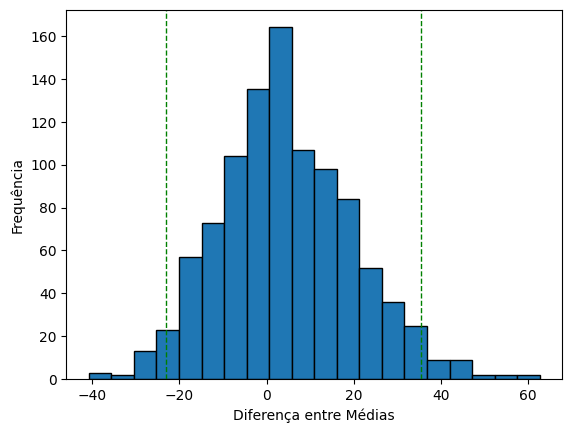

In [ ]:
plt.hist(mean_diffs, bins=20, edgecolor='black')
plt.ylabel('Frequência')
plt.xlabel('Diferença entre Médias')
plt.axvline(x=lower_diff, color='green', linestyle='--', linewidth=1)
plt.axvline(x=upper_diff, color='green', linestyle='--', linewidth=1)
plt.show()

**Hipótese Nula:** Não há diferença na média de homicídios entre municípios com alto e baixo idhm.

**Hipótese Alternativa:** Há uma diferença significativa na média de homicídios entre municípios com alto e baixo idhm.

In [ ]:
media_idhm = complete_df['idhm'].mean()

alta_idhm = complete_df[complete_df['idhm'] > media_idhm]['quantidade_homicidios']
baixa_idhm = complete_df[complete_df['idhm'] <= media_idhm]['quantidade_homicidios']

In [ ]:
mean_diffs, lower_diff, upper_diff = bootstrap_mean_diff(alta_idhm, baixa_idhm)
print(f"Média das Diferenças de Médias: {np.mean(mean_diffs)}")
print(f"Intervalo de Confiança: [{lower_diff}, {upper_diff}]")

Média das Diferenças de Médias: 60.354576662412136
Intervalo de Confiança: [34.816327502831356, 100.67973001719787]


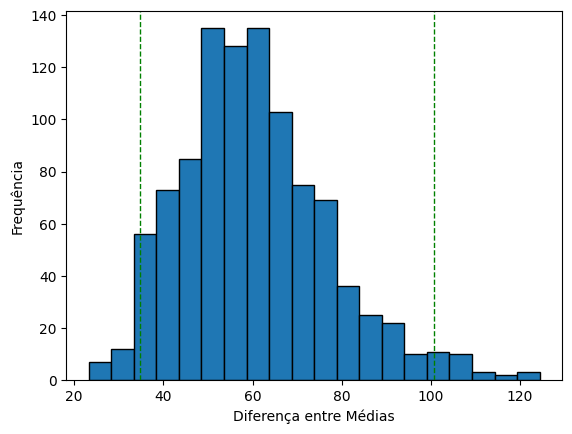

In [ ]:
plt.hist(mean_diffs, bins=20, edgecolor='black')
plt.ylabel('Frequência')
plt.xlabel('Diferença entre Médias')
plt.axvline(x=lower_diff, color='green', linestyle='--', linewidth=1)
plt.axvline(x=upper_diff, color='green', linestyle='--', linewidth=1)
plt.show()

### Previsão

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
X = complete_df.copy()[['populacao', 'densidade_demografica', 'escolarizacao', 'idhm', 'pib_per_capita']]
y = complete_df.copy()['quantidade_homicidios']

In [ ]:
# separa entre conjunto de teste, treino e validação
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

In [ ]:
def bootstrap_ic(model, X, y, n_bootstraps=1000, ci=95):
    np.random.seed(42)
    mse_scores = []
    r2_scores = []

    for _ in range(n_bootstraps):
        # amostra bootstrap
        indices = np.random.choice(len(X), len(X), replace=True)
        X_bootstrap = X[indices]
        y_bootstrap = y.iloc[indices]

        # previsões
        y_pred = model.predict(X_bootstrap)

        # calcula MSE e R²
        mse = mean_squared_error(y_bootstrap, y_pred)
        r2 = r2_score(y_bootstrap, y_pred)

        mse_scores.append(mse)
        r2_scores.append(r2)

    # calculo dos ICs
    lower_mse_ci = np.percentile(mse_scores, (100-ci)/2)
    upper_mse_ci = np.percentile(mse_scores, 100-(100-ci)/2)
    lower_r2_ci = np.percentile(r2_scores, (100-ci)/2)
    upper_r2_ci = np.percentile(r2_scores, 100-(100-ci)/2)

    return (lower_mse_ci, upper_mse_ci, mse_scores), (lower_r2_ci, upper_r2_ci, r2_scores)

In [ ]:
# agrupa todos os modelos utilizados
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    # validação cruzada
    mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_mse = -mse_scores.mean()

    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_r2 = r2_scores.mean()

    # treinamento
    model.fit(X_train, y_train)

    # avaliação no conjunto de validação
    y_valid_pred = model.predict(X_valid)
    mse_valid = mean_squared_error(y_valid, y_valid_pred)
    r2_valid = r2_score(y_valid, y_valid_pred)

    return mean_mse, mean_r2, mse_valid, r2_valid

for name, model in models.items():
    print(f"Modelo: {name}")
    mean_mse, mean_r2, mse_valid, r2_valid = evaluate_model(model, X_train_scaled, y_train, X_valid_scaled, y_valid)
    print(f"  MSE (validação cruzada): {mean_mse:.2f}")
    print(f"  R2 (validação cruzada): {mean_r2:.2f}")
    print(f"  MSE (conjunto de validação): {mse_valid:.2f}")
    print(f"  R2 (conjunto de validação): {r2_valid:.2f}\n")

Modelo: LinearRegression
  MSE (validação cruzada): 4219.75
  R2 (validação cruzada): 0.80
  MSE (conjunto de validação): 3325.86
  R2 (conjunto de validação): 0.69

Modelo: DecisionTreeRegressor
  MSE (validação cruzada): 104407.30
  R2 (validação cruzada): -1.23
  MSE (conjunto de validação): 3914.60
  R2 (conjunto de validação): 0.64

Modelo: RandomForestRegressor
  MSE (validação cruzada): 48343.89
  R2 (validação cruzada): 0.50
  MSE (conjunto de validação): 2963.34
  R2 (conjunto de validação): 0.73



In [ ]:
# importância de cada variável (regressão linear)
model = models['LinearRegression']
model.fit(X_train_scaled, y_train)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

print(feature_importances)

                 Feature  Coefficient
0              populacao   224.869762
1  densidade_demografica    64.081890
2          escolarizacao    -0.854390
3                   idhm   -14.589966
4         pib_per_capita     0.772259


In [ ]:
# importância de cada variável (árvore de decisão)
model = models['DecisionTreeRegressor']
model.fit(X_train_scaled, y_train)
feature_importances_tree = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

print(feature_importances_tree)

                 Feature  Importance
0              populacao    0.188200
1  densidade_demografica    0.760871
2          escolarizacao    0.014404
3                   idhm    0.002515
4         pib_per_capita    0.034010


In [ ]:
# importância de cada variável (random forest)
model = models['RandomForestRegressor']
model.fit(X_train_scaled, y_train)
feature_importances_tree = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

print(feature_importances_tree)

                 Feature  Importance
0              populacao    0.652552
1  densidade_demografica    0.208142
2          escolarizacao    0.013085
3                   idhm    0.088928
4         pib_per_capita    0.037293


In [ ]:
# ICs das métricas para regressão linear
(lower_mse, upper_mse, mse_scores), (lower_r2, upper_r2, r2_scores) = bootstrap_ic(models['LinearRegression'], X_valid_scaled, y_valid)
print(f"Intervalo de confiança para MSE (LinearRegression): [{lower_mse:.2f}, {upper_mse:.2f}]")
print(f"Intervalo de confiança para R2 (LinearRegression): [{lower_r2:.2f}, {upper_r2:.2f}]")

Intervalo de confiança para MSE (LinearRegression): [447.60, 8730.39]
Intervalo de confiança para R2 (LinearRegression): [0.57, 0.77]


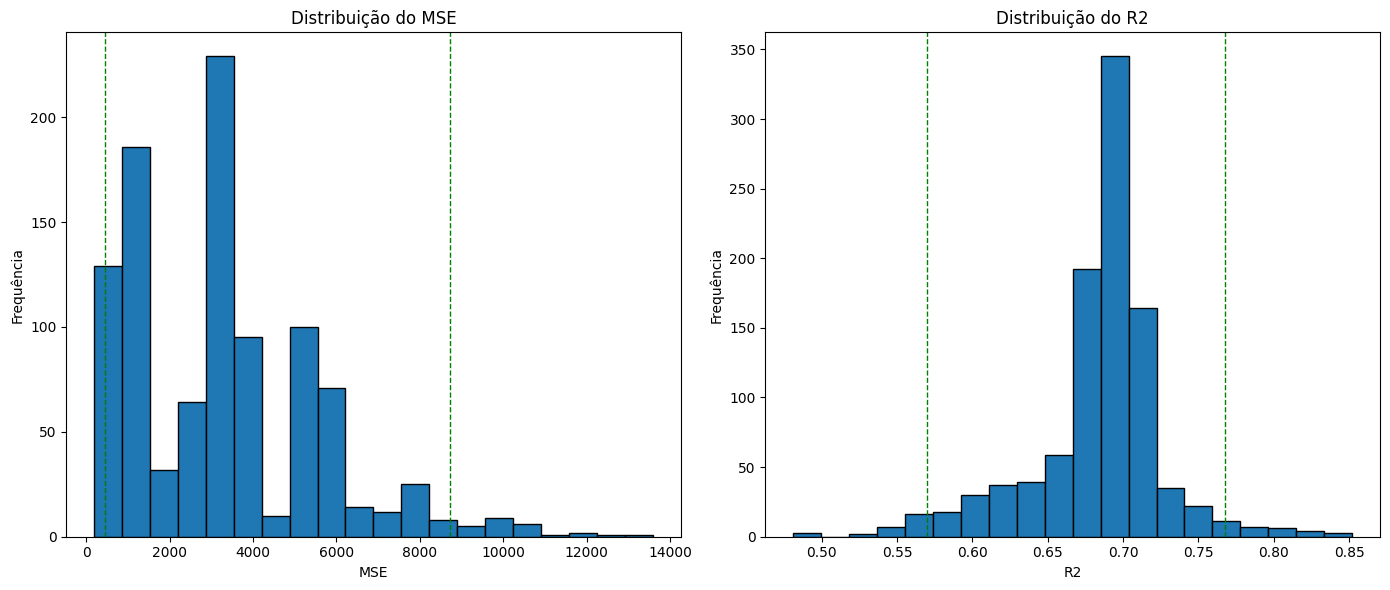

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# MSE
ax[0].hist(mse_scores, bins=20, edgecolor='black')
ax[0].set_ylabel('Frequência')
ax[0].set_xlabel('MSE')
ax[0].axvline(x=lower_mse, color='green', linestyle='--', linewidth=1)
ax[0].axvline(x=upper_mse, color='green', linestyle='--', linewidth=1)
ax[0].set_title('Distribuição do MSE')

# r2
ax[1].hist(r2_scores, bins=20, edgecolor='black')
ax[1].set_ylabel('Frequência')
ax[1].set_xlabel('R2')
ax[1].axvline(x=lower_r2, color='green', linestyle='--', linewidth=1)
ax[1].axvline(x=upper_r2, color='green', linestyle='--', linewidth=1)
ax[1].set_title('Distribuição do R2')

plt.tight_layout()
plt.show()

In [ ]:
# ICs das métricas para árvore de decisão
(lower_mse, upper_mse, mse_scores), (lower_r2, upper_r2, r2_scores) = bootstrap_ic(models['DecisionTreeRegressor'], X_valid_scaled, y_valid)
print(f"Intervalo de confiança para MSE (DecisionTreeRegressor): [{lower_mse:.2f}, {upper_mse:.2f}]")
print(f"Intervalo de confiança para R2 (DecisionTreeRegressor): [{lower_r2:.2f}, {upper_r2:.2f}]")

Intervalo de confiança para MSE (DecisionTreeRegressor): [770.46, 9304.62]
Intervalo de confiança para R2 (DecisionTreeRegressor): [0.17, 0.70]


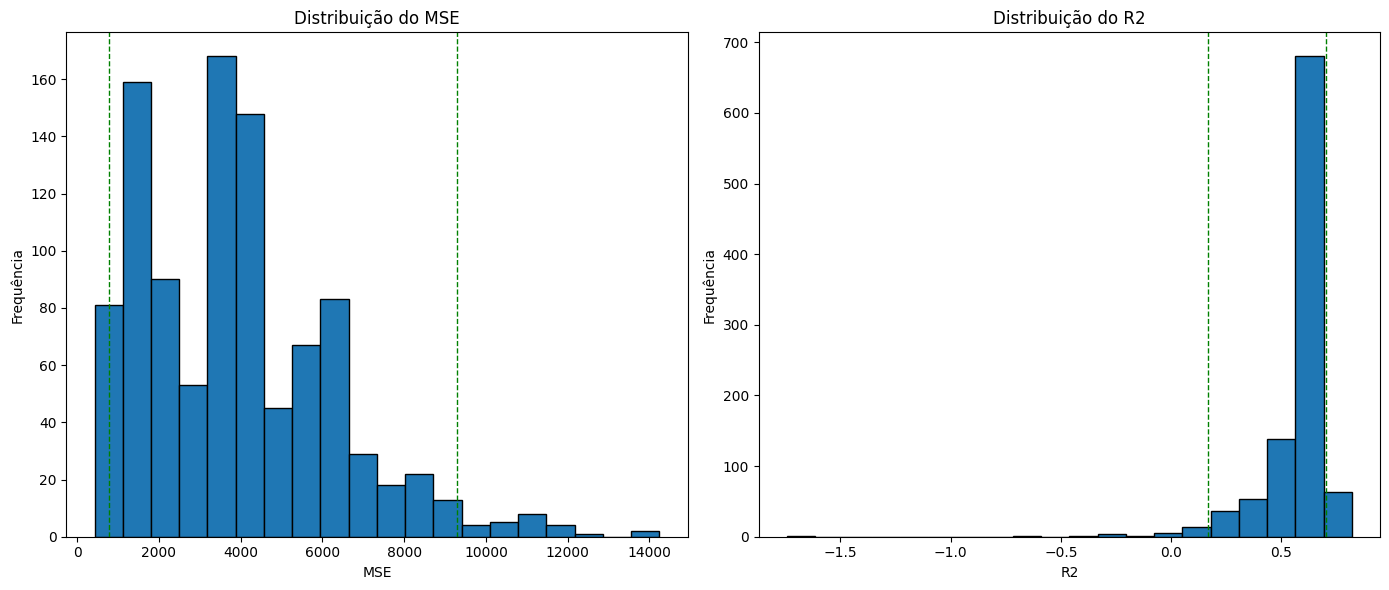

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# MSE
ax[0].hist(mse_scores, bins=20, edgecolor='black')
ax[0].set_ylabel('Frequência')
ax[0].set_xlabel('MSE')
ax[0].axvline(x=lower_mse, color='green', linestyle='--', linewidth=1)
ax[0].axvline(x=upper_mse, color='green', linestyle='--', linewidth=1)
ax[0].set_title('Distribuição do MSE')

# r2
ax[1].hist(r2_scores, bins=20, edgecolor='black')
ax[1].set_ylabel('Frequência')
ax[1].set_xlabel('R2')
ax[1].axvline(x=lower_r2, color='green', linestyle='--', linewidth=1)
ax[1].axvline(x=upper_r2, color='green', linestyle='--', linewidth=1)
ax[1].set_title('Distribuição do R2')

plt.tight_layout()
plt.show()

In [ ]:
# ICs das métricas para random forest
(lower_mse, upper_mse, mse_scores), (lower_r2, upper_r2, r2_scores) = bootstrap_ic(models['RandomForestRegressor'], X_valid_scaled, y_valid)
print(f"Intervalo de confiança para MSE (RandomForestRegressor): [{lower_mse:.2f}, {upper_mse:.2f}]")
print(f"Intervalo de confiança para R2 (RandomForestRegressor): [{lower_r2:.2f}, {upper_r2:.2f}]")

Intervalo de confiança para MSE (RandomForestRegressor): [505.45, 7588.27]
Intervalo de confiança para R2 (RandomForestRegressor): [0.60, 0.75]


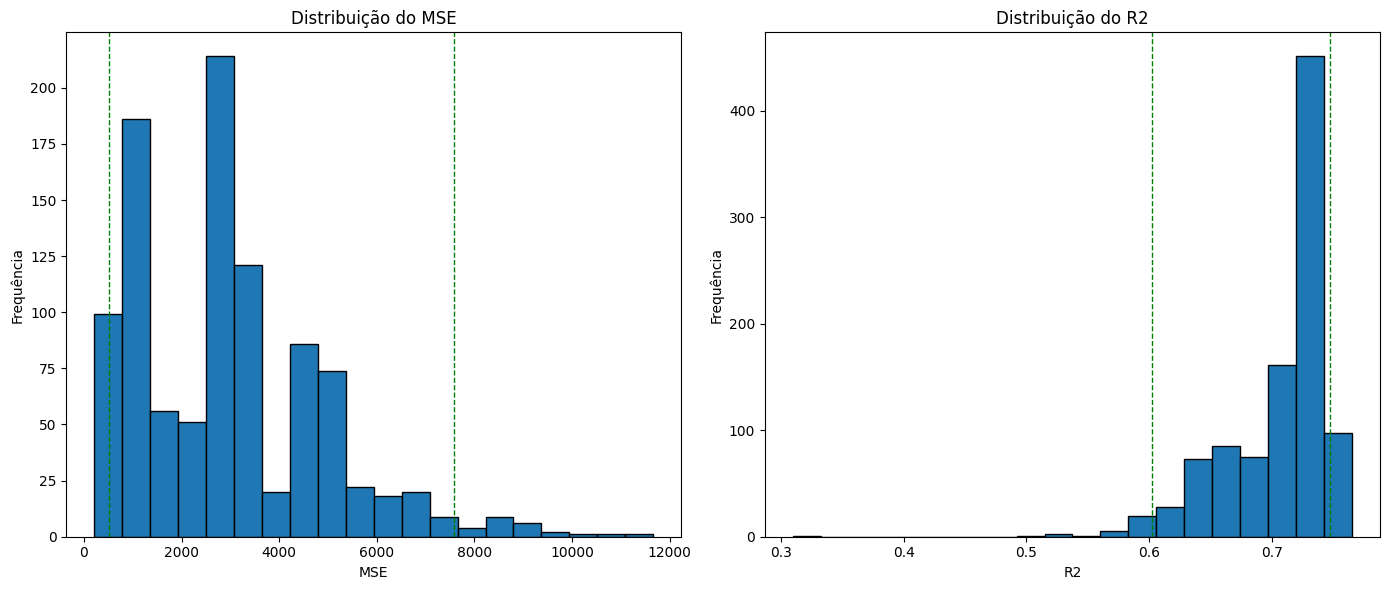

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# MSE
ax[0].hist(mse_scores, bins=20, edgecolor='black')
ax[0].set_ylabel('Frequência')
ax[0].set_xlabel('MSE')
ax[0].axvline(x=lower_mse, color='green', linestyle='--', linewidth=1)
ax[0].axvline(x=upper_mse, color='green', linestyle='--', linewidth=1)
ax[0].set_title('Distribuição do MSE')

# r2
ax[1].hist(r2_scores, bins=20, edgecolor='black')
ax[1].set_ylabel('Frequência')
ax[1].set_xlabel('R2')
ax[1].axvline(x=lower_r2, color='green', linestyle='--', linewidth=1)
ax[1].axvline(x=upper_r2, color='green', linestyle='--', linewidth=1)
ax[1].set_title('Distribuição do R2')

plt.tight_layout()
plt.show()

## Resultados

### Caracterização

- **Distribuição de Homicídios**: Através de um histograma, vemos uma distribuição desigual dos homicídios entre os municípios. A maioria dos municípios apresenta poucos homicídios, enquanto um número reduzido de municípios tem índices significativamente altos. Essa desigualdade destaca a concentração de homicídios em alguns locais específicos.

- **Análise de Correlação**: A análise de correlação mostrou que a variável com a maior correlação com a quantidade de homicídios é a população total dos municípios. Em seguida, a densidade populacional também apresentou uma correlação considerável. Por outro lado, a escolarização demonstrou uma correlação muito baixa com a quantidade de homicídios, sugerindo que a relação entre escolarização e homicídios é fraca.

- **Testes de Hipótese**: Os testes de hipótese, conduzidos por meio de bootstrap, revelaram que existe uma diferença significativa na média de homicídios entre municípios com alto e baixo Índice de Desenvolvimento Humano Municipal (IDHM). No entanto, não foi encontrada uma diferença estatisticamente significativa na quantidade de homicídios entre municípios com alta e baixa escolarização.

### Previsão

- **Linear Regression**: Apresentou as melhores métricas de desempenho, com o menor erro quadrático médio (MSE) e o maior coeficiente de determinação (R²). Esse desempenho indica que o modelo linear é eficaz em capturar a relação entre as variáveis socioeconômicas e a quantidade de homicídios.

- **Decision Tree Regressor**: Apresentou um desempenho inferior ao da regressão linear e random forest. A análise de importância das variáveis revelou que a densidade populacional foi considerada a variável mais importante para este modelo.

- **Random Forest Regressor**: Mostrou um desempenho robusto, com métricas de MSE e R² que foram superiores às da árvore de decisão, mas inferiores às da regressão linear. O random forest identificou a população como a variável mais importante para a previsão de homicídios, alinhando-se com os resultados da regressão linear.

- **Importância das Variáveis**: Tanto o modelo de regressão linear quanto o de random forest atribuíram a maior importância à população total dos municípios. Em contraste, a árvore de decisão destacou a densidade populacional como a variável mais relevante para a previsão de homicídios.

## Conclusão

O estudo revelou que a maioria dos municípios tem baixos índices de homicídios, com a população e a densidade populacional sendo as variáveis mais correlacionadas com homicídios. A diferença de homicídios foi significativa apenas entre municípios com diferentes IDHM, não entre níveis de escolarização. A regressão linear apresentou o melhor desempenho entre os modelos, seguido por random forest e árvore de decisão.

### Limitações

- **Dados**: A análise enfrentou limitações devido à qualidade e quantidade dos dados disponíveis. A presença de dados ausentes e a variabilidade nas informações socioeconômicas podem ter afetado a robustez dos resultados.

- **Modelo**: A quantidade limitada de dados impediu a aplicação de modelos mais complexos, que poderiam potencialmente oferecer resultados mais precisos.

- **Generalização**: Os resultados são específicos para os municípios de Minas Gerais e não são aplicáveis a outras regiões com características socioeconômicas diferentes.

# Relatório - Análise da Relação entre Posse Ilegal de Arma de Fogo e Roubo de Veículos no Brasil
Autor: Victor Henrique Silva Ribeiro

## Introdução
Este estudo tem como motivação investigar a possível relação entre a posse ilegal de armas de fogo e a incidência de roubo de veículos no Brasil, buscando entender se existe uma correlação entre esses dois fenômenos.

**Pergunta de pesquisa**: Existe uma relação entre a quantidade de posse ilegal de armas de fogo e a quantidade de roubos ou furtos de veículos no Brasil?

## Metodologia
### Base de Dados:
Os dados utilizados neste estudo foram obtidos a partir de duas fontes:
 - **Base de dados de Segurança Pública (FBSP/ABSP)**: Fornecida pelo **BasedosDados**, essa base contém informações sobre crimes violentos, incluindo homicídios, roubos e posse ilegal de armas de fogo, a nível municipal, para o período de 2018 a 2021.

 - **Base de dados de População (IBGE)**: Também disponibilizada pelo **BasedosDados**, essa base contém dados sobre a população por Unidade da Federação (UF) para os anos em análise.

### Métodos e Modelos
Para responder à pergunta de pesquisa, foram utilizados os seguintes métodos e modelos:

- **Limpeza e Preparação dos Dados**: Inicialmente, os dados foram limpos e preparados, incluindo a remoção de valores ausentes, a agregação dos dados de crimes por UF e ano, e a normalização das taxas de crimes por 100 mil habitantes.

- **Análise Exploratória dos Dados**: Foram calculadas estatísticas descritivas e geradas visualizações (histogramas, gráficos de barras, boxplots e scatterplots) para analisar a distribuição dos dados e identificar possíveis padrões e relações entre as variáveis.

- **Clusterização**: Foi aplicado o algoritmo K-means para agrupar as UFs em clusters com base nas taxas de posse ilegal de armas de fogo e roubo/furto de veículos. O método do cotovelo foi utilizado para determinar o número ideal de clusters.
- **Regressão Linear**: Modelos de regressão linear foram ajustados para cada cluster, a fim de quantificar a relação entre as variáveis de interesse dentro de cada grupo.

A escolha do K-means se justifica pela sua capacidade de identificar grupos de UFs com comportamentos semelhantes em relação às variáveis analisadas. A regressão linear, por sua vez, permite quantificar a relação entre as variáveis e avaliar a significância estatística dessa relação.

### Código


#### Importando as bases de dados

In [ ]:
!pip install basedosdados
!pip install geopandas
!pip install dbfread

import basedosdados as bd

In [ ]:
billing_project_id="resolute-grin-426710-h3"

In [ ]:
violencia_df_raw = bd.read_table(dataset_id='br_fbsp_absp',
  table_id='municipio',
  billing_project_id=billing_project_id)

Downloading: 100%|██████████| 162/162 [00:00<00:00, 498.98rows/s]


In [ ]:
populacao_df_raw = bd.read_table(dataset_id='br_ibge_populacao',
  table_id='uf',
  billing_project_id=billing_project_id)

Downloading: 100%|██████████| 837/837 [00:00<00:00, 3103.04rows/s]


#### Compreensão dos Dados:

Variáveis:
- Identificadores: 'sigla_uf', 'ano'
- Informações sobre população: 'populacao', 'populacao_economicamente_ativa'

In [ ]:
print(populacao_df_raw.columns)
print(populacao_df_raw.shape)

Index(['sigla_uf', 'ano', 'populacao', 'populacao_economicamente_ativa'], dtype='object')
(837, 4)


Variáveis:
- Identificadores: 'ano', 'sigla_uf', 'id_municipio', 'grupo'
- Crimes Violentos: 'quantidade_homicidio_doloso', 'quantidade_latrocinio', 'quantidade_lesao_corporal_morte', 'quantidade_feminicidio'
- Mortes em Intervenções: 'quantidade_mortes_policiais_confronto', ..., 'quantidade_morte_policiais_militares_fora_de_servico'
- Roubo e Furto de Veículos: 'quantidade_roubo_veiculos', 'quantidade_furto_veiculos', 'quantidade_roubo_furto_veiculos'
- Armas de Fogo: 'quantidade_posse_ilegal_arma_de_fogo', 'quantidade_porte_ilegal_arma_de_fogo', 'quantidade_posse_ilegal_porte_ilegal_arma_de_fogo'
- Drogas: 'quantidade_trafico_entorpecente', 'quantidade_posse_uso_entorpecente'
- Proporção: 'proporcao_mortes_intenvencao_policial_x_mortes_violentas_intencionais'

In [ ]:
print(violencia_df_raw.columns)
print(violencia_df_raw.shape)

Index(['ano', 'sigla_uf', 'id_municipio', 'grupo',
       'quantidade_homicidio_doloso', 'quantidade_latrocinio',
       'quantidade_lesao_corporal_morte',
       'quantidade_mortes_policiais_confronto',
       'quantidade_mortes_intervencao_policial',
       'quantidade_mortes_intervencao_policial_civil_em_servico',
       'quantidade_mortes_intervencao_policial_militar_em_servico',
       'quantidade_mortes_intervencao_policial_civil_fora_de_servico',
       'quantidade_mortes_intervencao_policial_militar_fora_de_servico',
       'quantidade_mortes_violentas_intencionais', 'quantidade_feminicidio',
       'quantidade_lesao_corporal_dolosa_violencia_domestica',
       'quantidade_estupro', 'quantidade_roubo_veiculos',
       'quantidade_furto_veiculos', 'quantidade_roubo_furto_veiculos',
       'proporcao_mortes_intenvencao_policial_x_mortes_violentas_intencionais',
       'quantidade_posse_ilegal_arma_de_fogo',
       'quantidade_porte_ilegal_arma_de_fogo',
       'quantidade_posse_i

#### Limpeza e Preparação:


- Valores Ausentes: Verificar e tratar valores ausentes em cada coluna.

In [ ]:
populacao_df = populacao_df_raw.copy()[['sigla_uf', 'ano', 'populacao']]

# Verificar valores ausentes:
missing_values = populacao_df.isnull().sum()
print(f"{missing_values.sum()} valores nulos")

# Excluir as linhas com valores ausentes.
populacao_df = populacao_df.dropna()

print(populacao_df.shape)
print(populacao_df.head())

0 valores nulos
(837, 3)
  sigla_uf   ano  populacao
0       AC  1991     417102
1       AL  1991    2512658
2       AM  1991    2102766
3       AP  1991     289035
4       BA  1991   11867336


- Valores Ausentes: Verificar e tratar valores ausentes em cada coluna.
- Agrupar por unidade federativa.
- Filtrar regiões do nordeste

In [ ]:
violencia_df = violencia_df_raw.copy()[['ano', 'sigla_uf',
                                        'quantidade_posse_ilegal_porte_ilegal_arma_de_fogo',
                                        'quantidade_roubo_veiculos']]

# Verificar valores ausentes:
missing_values = violencia_df.isnull().sum()
print(f"{missing_values.sum()} valores nulos")

# Excluir as linhas com valores ausentes.
violencia_df = violencia_df.dropna()

# Agrupando por UF e ano
violencia_df = violencia_df.groupby(['sigla_uf', 'ano'], as_index=False).sum()

# Filtrando regiões do nordeste
# siglas_nordeste = ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
# siglas_nordeste = ['MG']
# violencia_df = violencia_df.loc[violencia_df['sigla_uf'].isin(siglas_nordeste)]

print(violencia_df.shape)
print(violencia_df.head())

69 valores nulos
(98, 4)
  sigla_uf   ano  quantidade_posse_ilegal_porte_ilegal_arma_de_fogo  \
0       AC  2019                                                 57   
1       AC  2020                                                 44   
2       AC  2021                                                 64   
3       AL  2018                                                538   
4       AL  2019                                                700   

   quantidade_roubo_veiculos  
0                        738  
1                        798  
2                        792  
3                       1009  
4                        602  


Normalizar as quantidade de 'violencia_df' pelas populações das respectivas unidades federativas nos anos correspondentes

In [ ]:
violencia_df = violencia_df.merge(populacao_df, on=['sigla_uf', 'ano']) # Mesclar os DataFrames com base em 'sigla_uf' e 'ano'

colunas_para_normalizar = ['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo',
                            'quantidade_roubo_veiculos']
for coluna in colunas_para_normalizar:
    violencia_df[coluna + '_por_100k_habitantes'] = (violencia_df[coluna] / violencia_df['populacao']) * 100000

violencia_df = violencia_df.drop(colunas_para_normalizar + ['populacao'], axis=1) # Remover colunas originais

print(violencia_df.shape)
print(violencia_df.head())

(98, 4)
  sigla_uf   ano  \
0       AC  2019   
1       AC  2020   
2       AC  2021   
3       AL  2018   
4       AL  2019   

   quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes  \
0                                           6.463061                       
1                                           4.919114                       
2                                           7.057194                       
3                                          16.191067                       
4                                          20.974681                       

   quantidade_roubo_veiculos_por_100k_habitantes  
0                                      83.679636  
1                                      89.214842  
2                                      87.332778  
3                                      30.365774  
4                                      18.038226  


#### Análise exploratória dos dados:
- Estatísticas Descritivas: Calcular medidas resumo para cada variável numérica, como média, mediana, desvio padrão, mínimo, máximo. Isso dará uma ideia da distribuição dos dados.
- Visualizações:
As visualizações buscam entender se existe uma relação entre as duas variáveis de interesse.

In [ ]:
print(violencia_df['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes'].describe())
print(violencia_df['quantidade_roubo_veiculos_por_100k_habitantes'].describe())

count         98.0
mean       7.42569
std       7.832854
min        0.73869
25%       2.488895
50%        4.83549
75%       8.760926
max      41.449516
Name: quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes, dtype: Float64
count          98.0
mean      38.498727
std       33.380007
min         1.58071
25%       11.777878
50%         28.5955
75%        55.11374
max      144.510826
Name: quantidade_roubo_veiculos_por_100k_habitantes, dtype: Float64


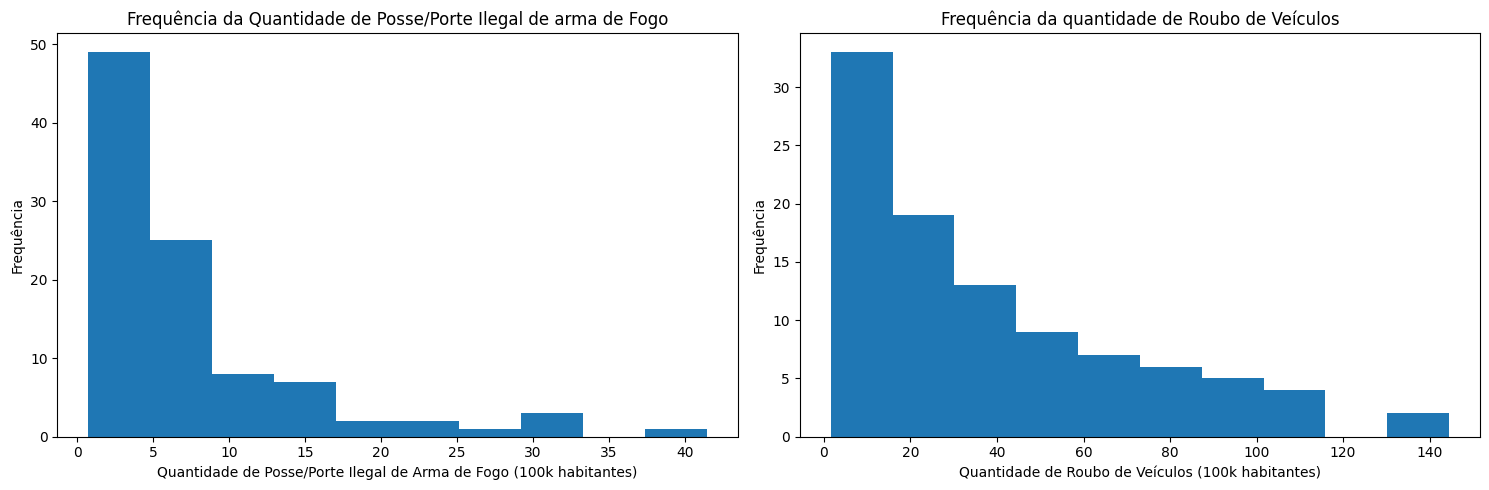

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize=(15, 5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].hist(violencia_df['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes'])
axes[0].set_xlabel('Quantidade de Posse/Porte Ilegal de Arma de Fogo (100k habitantes)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Frequência da Quantidade de Posse/Porte Ilegal de arma de Fogo')

axes[1].hist(violencia_df['quantidade_roubo_veiculos_por_100k_habitantes'])
axes[1].set_xlabel('Quantidade de Roubo de Veículos (100k habitantes)')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Frequência da quantidade de Roubo de Veículos')

plt.tight_layout()
plt.show()

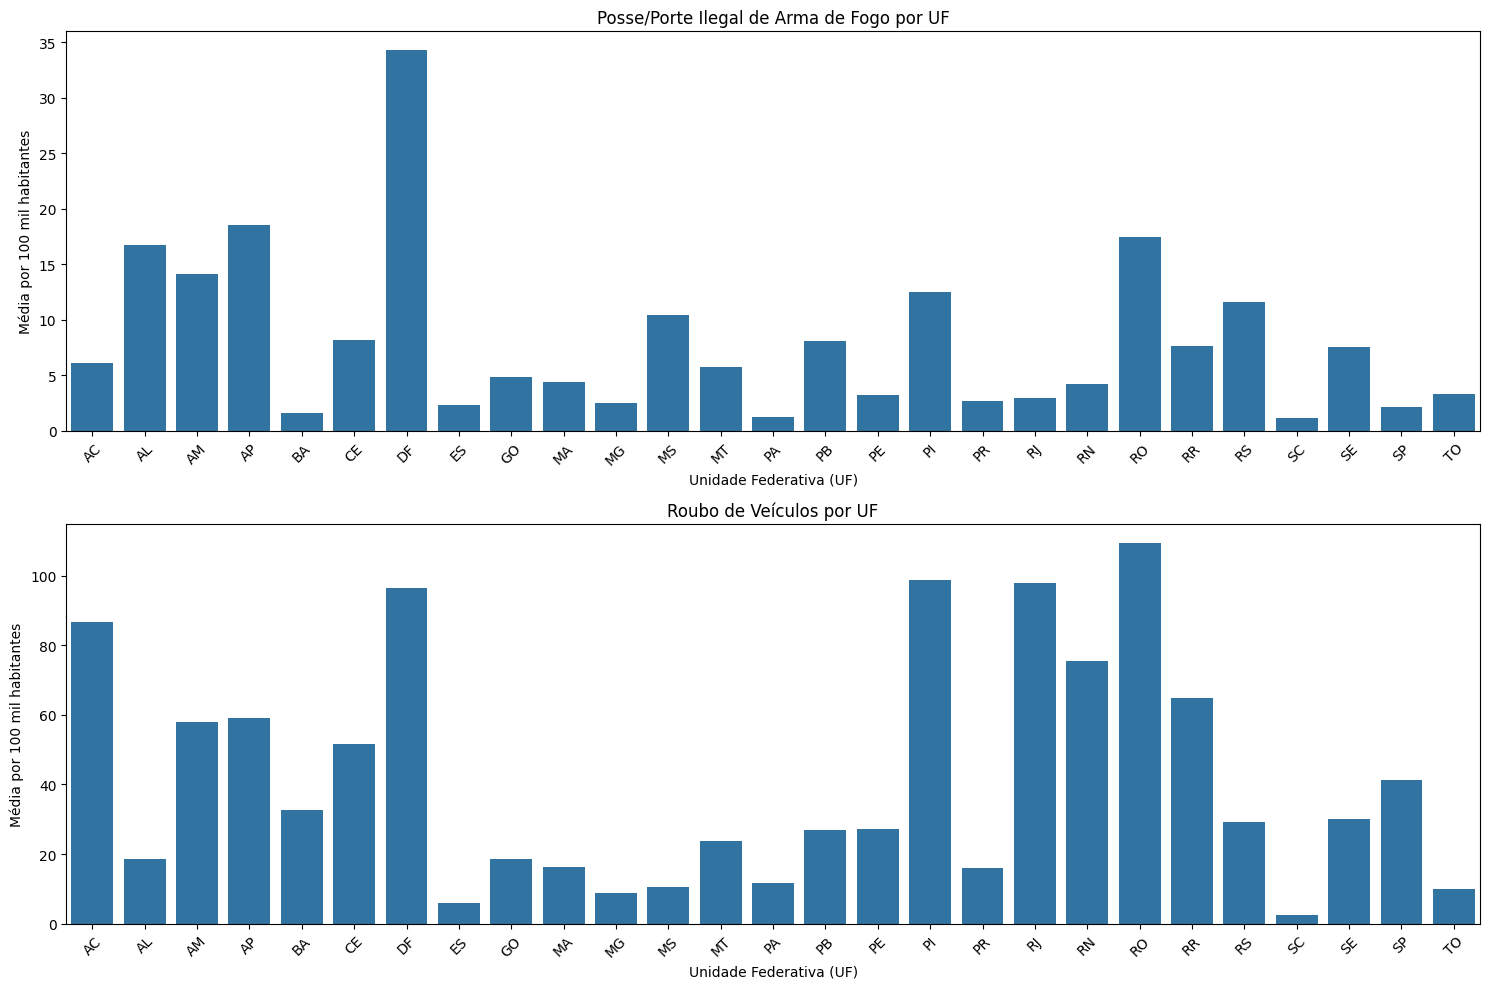

     ano                                                                   \
   count         mean       std     min      25%     50%      75%     max   
0    3.0       2020.0       1.0  2019.0   2019.5  2020.0   2020.5  2021.0   
1    4.0       2019.5  1.290994  2018.0  2018.75  2019.5  2020.25  2021.0   
2    4.0       2019.5  1.290994  2018.0  2018.75  2019.5  2020.25  2021.0   
3    2.0       2018.5  0.707107  2018.0  2018.25  2018.5  2018.75  2019.0   
4    4.0       2019.5  1.290994  2018.0  2018.75  2019.5  2020.25  2021.0   
5    3.0  2019.666667  1.527525  2018.0   2019.0  2020.0   2020.5  2021.0   
6    4.0       2019.5  1.290994  2018.0  2018.75  2019.5  2020.25  2021.0   
7    4.0       2019.5  1.290994  2018.0  2018.75  2019.5  2020.25  2021.0   
8    4.0       2019.5  1.290994  2018.0  2018.75  2019.5  2020.25  2021.0   
9    4.0       2019.5  1.290994  2018.0  2018.75  2019.5  2020.25  2021.0   
10   4.0       2019.5  1.290994  2018.0  2018.75  2019.5  2020.25  2021.0   

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize = (15, 10)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)

sns.barplot(x='sigla_uf',
            y='quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes',
            data=violencia_df,
            ci=None,
            ax=axes[0])
axes[0].set_xlabel('Unidade Federativa (UF)')
axes[0].set_ylabel('Média por 100 mil habitantes')
axes[0].set_title('Posse/Porte Ilegal de Arma de Fogo por UF')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='sigla_uf',
            y='quantidade_roubo_veiculos_por_100k_habitantes',
            data=violencia_df,
            ci=None,
            ax=axes[1])
axes[1].set_xlabel('Unidade Federativa (UF)')
axes[1].set_ylabel('Média por 100 mil habitantes')
axes[1].set_title('Roubo de Veículos por UF')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(violencia_df.groupby('sigla_uf', as_index=False).describe())

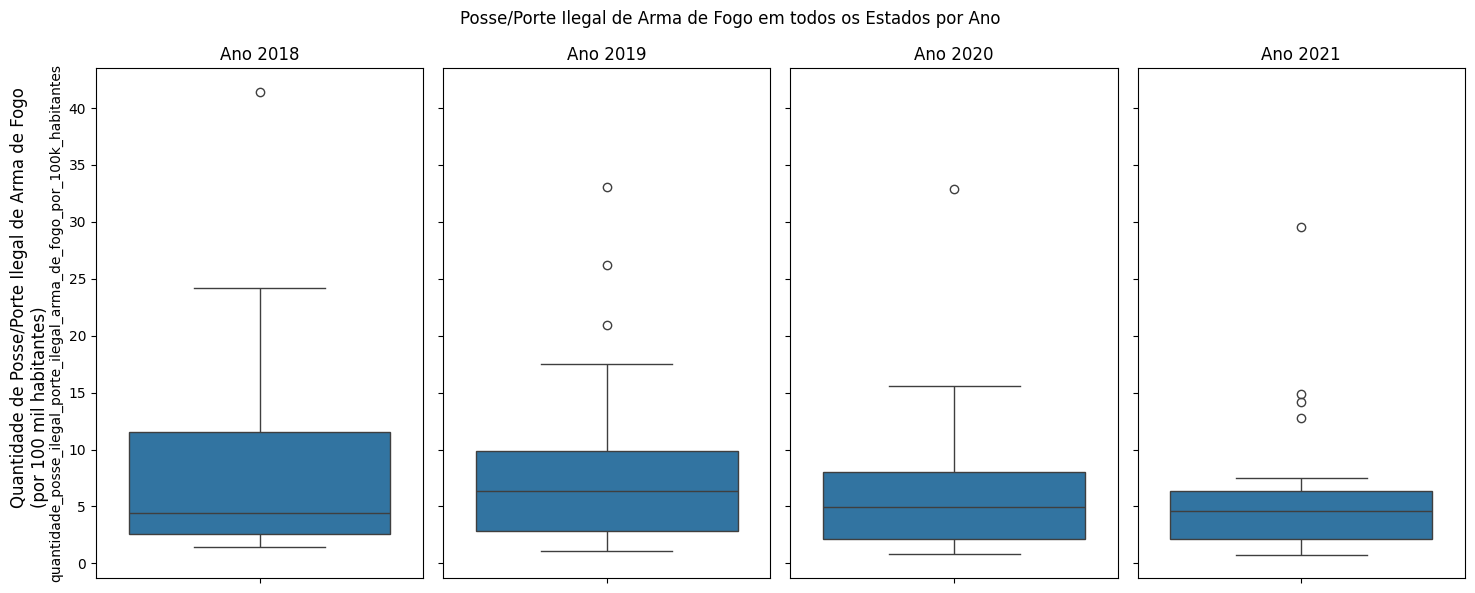

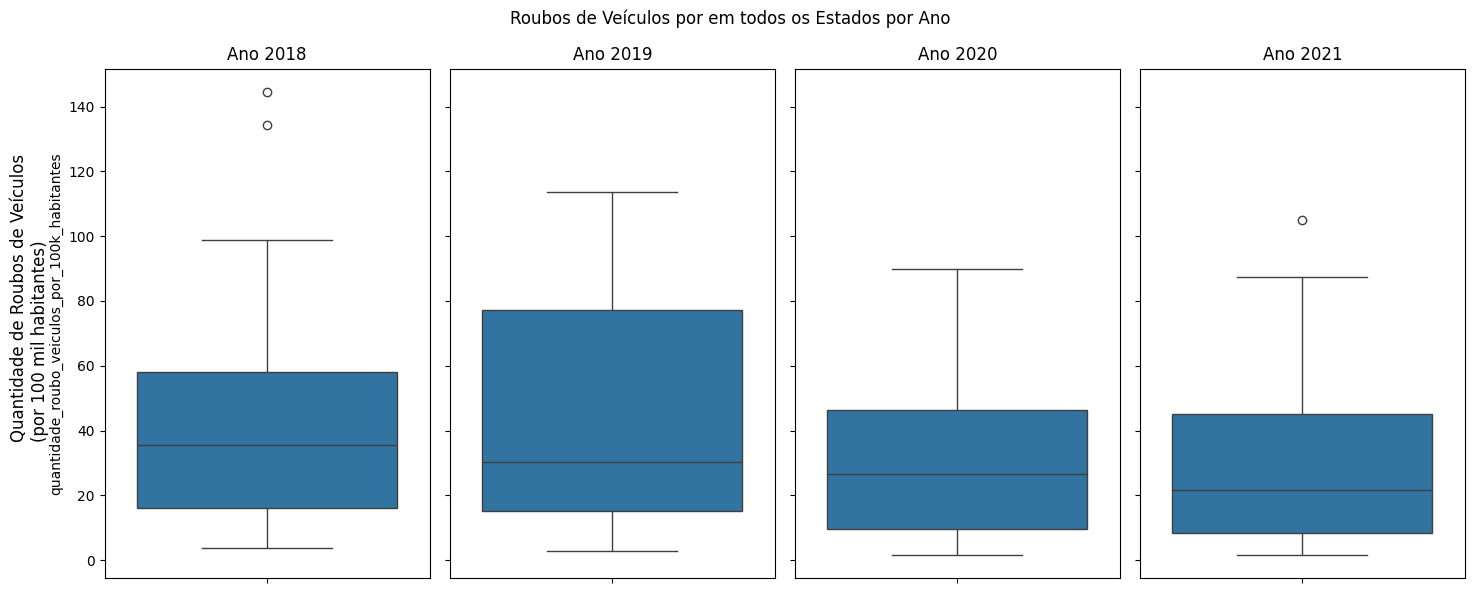

In [ ]:
num_anos = len(violencia_df['ano'].unique())

fig, axes = plt.subplots(1, num_anos, figsize=(15, 6), sharey=True)

for i, ano in enumerate(sorted(violencia_df['ano'].unique())):
    violencia_boxplot_df = violencia_df[violencia_df['ano'] == ano][['ano', 'quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes']]

    sns.boxplot(y='quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes',
                data=violencia_boxplot_df,
                ax=axes[i])
    axes[i].set_title(f'Ano {ano}')
    axes[i].set_xlabel('')

fig.supylabel('Quantidade de Posse/Porte Ilegal de Arma de Fogo\n(por 100 mil habitantes)')
fig.suptitle('Posse/Porte Ilegal de Arma de Fogo em todos os Estados por Ano')
plt.tight_layout()
plt.show()

num_anos = len(violencia_df['ano'].unique())

fig, axes = plt.subplots(1, num_anos, figsize=(15, 6), sharey=True)

for i, ano in enumerate(sorted(violencia_df['ano'].unique())):
    violencia_boxplot_df = violencia_df[violencia_df['ano'] == ano][['ano', 'quantidade_roubo_veiculos_por_100k_habitantes']]

    sns.boxplot(y='quantidade_roubo_veiculos_por_100k_habitantes',
                data=violencia_boxplot_df,
                ax=axes[i])
    axes[i].set_title(f'Ano {ano}')
    axes[i].set_xlabel('')

fig.supylabel('Quantidade de Roubos de Veículos\n(por 100 mil habitantes)')
fig.suptitle('Roubos de Veículos por em todos os Estados por Ano')
plt.tight_layout()
plt.show()

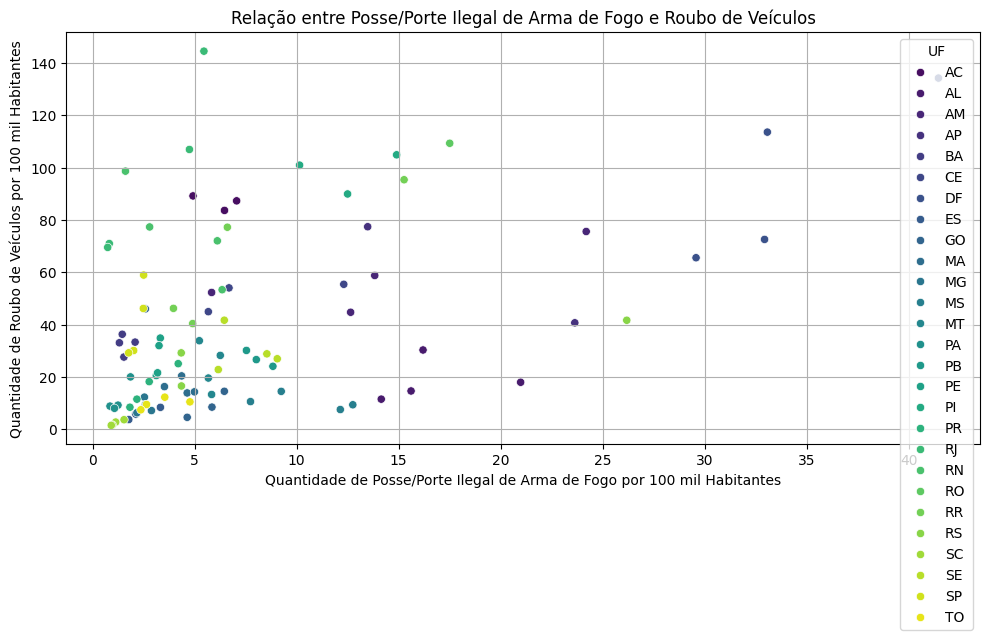

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize = (10, 6)
plt.figure(figsize=figsize)

sns.scatterplot(x='quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes',
                y='quantidade_roubo_veiculos_por_100k_habitantes',
                data=violencia_df,
                hue='sigla_uf',
                palette='viridis')

plt.xlabel('Quantidade de Posse/Porte Ilegal de Arma de Fogo por 100 mil Habitantes')
plt.ylabel('Quantidade de Roubo de Veículos por 100 mil Habitantes')
plt.title('Relação entre Posse/Porte Ilegal de Arma de Fogo e Roubo de Veículos')
plt.grid(True)
plt.legend(title='UF')
plt.tight_layout()
plt.show()

#### Treinando o modelo

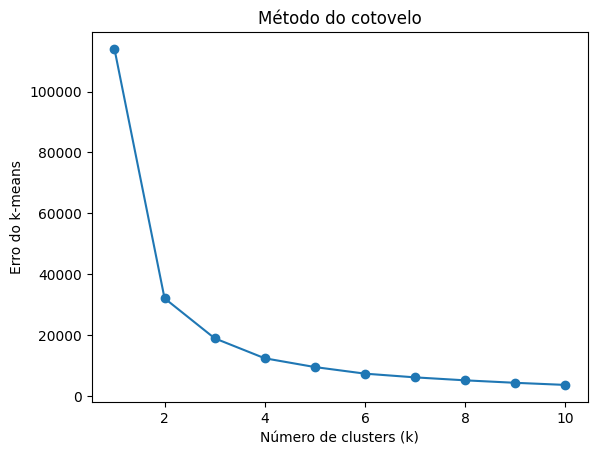

In [ ]:
from sklearn.cluster import KMeans

errors = []
X = violencia_df[['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes',
                  'quantidade_roubo_veiculos_por_100k_habitantes']]
n_samples = 30
for k in range(1, 11):
  k_errors = []
  for i in range(n_samples):
    kmeans = KMeans(n_clusters=k, random_state=i)
    kmeans.fit(X)
    k_errors.append(kmeans.inertia_)

  mean_error = sum(k_errors) / n_samples
  errors.append(mean_error)

plt.plot(range(1, 11), errors, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Erro do k-means')
plt.title('Método do cotovelo')
plt.show()


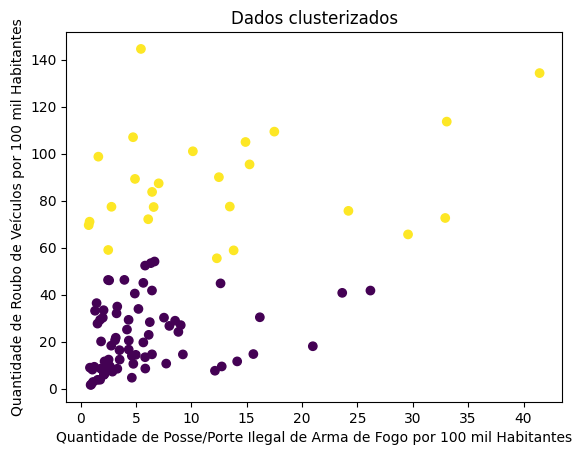

In [ ]:
import sys

min_error = sys.maxsize
random_state = None
k = 2
samples = 100
for i in range(samples):
  kmeans = KMeans(n_clusters=k, random_state=i)
  labels = kmeans.fit_predict(X)

  error = kmeans.inertia_
  if error < min_error:
    min_error = error
    random_state = i

kmeans = KMeans(n_clusters=k, random_state=random_state)
labels = kmeans.fit_predict(X)
X_array = X.values

plt.scatter(X_array[:, 0], X_array[:, 1], c=labels, cmap='viridis')
plt.xlabel('Quantidade de Posse/Porte Ilegal de Arma de Fogo por 100 mil Habitantes')
plt.ylabel('Quantidade de Roubo de Veículos por 100 mil Habitantes')
plt.title('Dados clusterizados')
plt.show()

In [ ]:
import numpy as np

data = violencia_df[['sigla_uf', 'ano',
                     'quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes',
                     'quantidade_roubo_veiculos_por_100k_habitantes']]

unique_labels = np.unique(labels)
clusters_data = []

for label in unique_labels:
  cluster_data = data[labels == label]
  clusters_data.append(cluster_data)

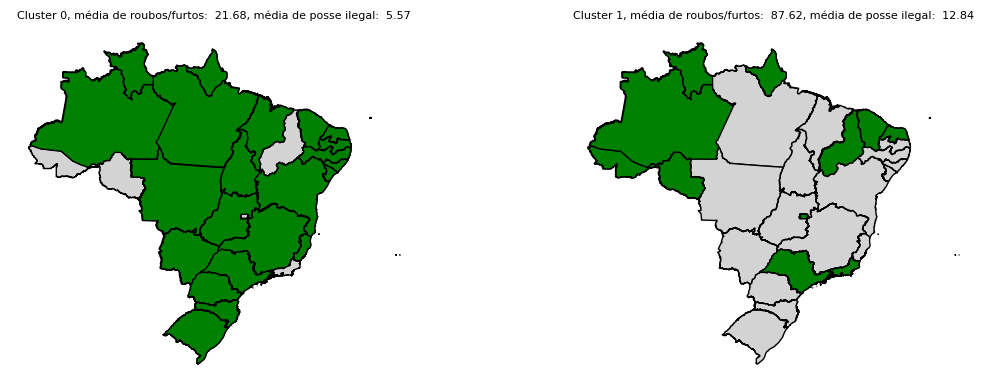

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from dbfread import DBF
from pandas import DataFrame

states = gpd.read_file("BR_UF_2021.shp")

fig, axes = plt.subplots(1, k, figsize=(12, 4))
for i, cluster_data in enumerate(clusters_data):
  # Plota todos os estados em cinza
  states.plot(ax=axes[i], facecolor="lightgrey", edgecolor="black")
  mean_theft = cluster_data['quantidade_roubo_veiculos_por_100k_habitantes'].mean()
  mean_firearm = cluster_data['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes'].mean()

  # Pinta um estado especifico de verde
  for sigla in cluster_data['sigla_uf'].unique():
    states[states["SIGLA"] == sigla].plot(ax=axes[i], facecolor="green", edgecolor="black")

    axes[i].set_title(f"Cluster {i}, média de roubos/furtos: {mean_theft: .2f}, média de posse ilegal: {mean_firearm: .2f}", fontsize=8)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

----- Resultados da regressão para o Cluster 0 -----

                                          OLS Regression Results                                         
Dep. Variable:     quantidade_roubo_veiculos_por_100k_habitantes   R-squared:                       0.065
Model:                                                       OLS   Adj. R-squared:                  0.052
Method:                                            Least Squares   F-statistic:                     4.922
Date:                                           Tue, 09 Jul 2024   Prob (F-statistic):             0.0297
Time:                                                   18:36:12   Log-Likelihood:                -294.97
No. Observations:                                             73   AIC:                             593.9
Df Residuals:                                                 71   BIC:                             598.5
Df Model:                                                      1                                  

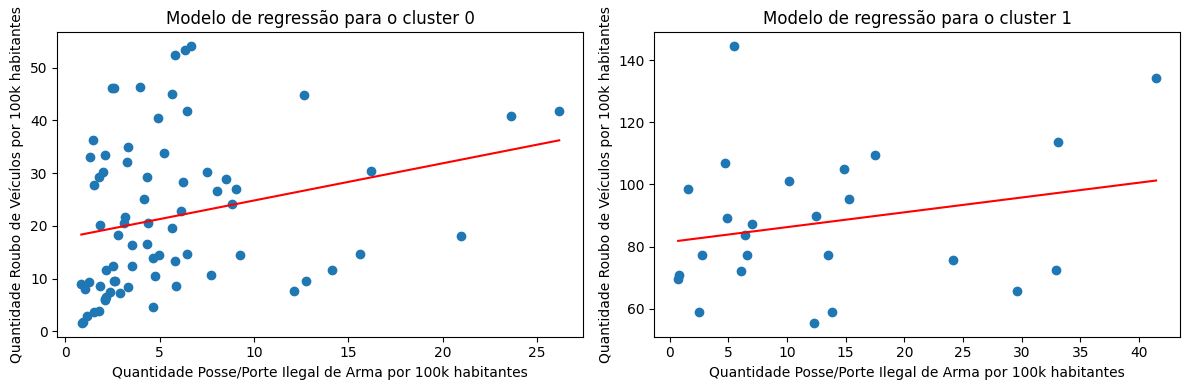

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, k, figsize=(12, 4))
for i, cluster_data in enumerate(clusters_data):
    X = cluster_data[['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes']].astype(float)
    y = cluster_data['quantidade_roubo_veiculos_por_100k_habitantes'].astype(float)

    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()

    print(f"----- Resultados da regressão para o Cluster {i} -----\n")
    print(results.summary())
    print("-" * 50)

    intercept = results.params['const']
    slope = results.params['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes']

    x_values = np.linspace(X['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes'].min(),
                        X['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes'].max(), 100)
    y_values = slope * x_values + intercept

    axes[i].scatter(X['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo_por_100k_habitantes'], y)
    axes[i].plot(x_values, y_values, color='red')
    axes[i].set_xlabel('Quantidade Posse/Porte Ilegal de Arma por 100k habitantes')
    axes[i].set_ylabel('Quantidade Roubo de Veículos por 100k habitantes')
    axes[i].set_title(f"Modelo de regressão para o cluster {i}")

plt.tight_layout()
plt.show()

## Resultados
### Caracterização (Análise Exploratória)
A análise exploratória dos dados revelou os seguintes pontos:
- **Variabilidade**: Existe uma grande variabilidade entre as UFs em relação às taxas de posse ilegal de armas de fogo e roubo de veículos.
- **Distribuição**: As distribuições das taxas de posse ilegal de armas de fogo e roubo de veículos não seguem uma distribuição normal.
- **Tendência**: Não foi observada uma tendência clara de aumento ou diminuição das taxas de crimes ao longo dos anos analisados.
- **Correlação**: O scatterplot sugere que as variáveis em questão não possuem relação.

### Clusterização
O método do cotovelo indicou que o número ideal de clusters é 2. A clusterização com K-means resultou em dois grupos distintos de UFs:
- **Cluster 0**: Caracterizado por baixas taxas de posse ilegal de armas de fogo e roubo de veículos.
- **Cluster 1**: Apresenta altas taxas de posse ilegal de armas de fogo e roubo de veículos.
A visualização dos clusters no mapa do Brasil permitiu identificar a distribuição geográfica dos grupos, revelando um padrão sem uma clara divisão regional. A distribuição dos clusters no mapa sugere que outros fatores, além da localização geográfica, podem estar influenciando a formação dos grupos.

### Regressão Linear
Os modelos de regressão linear ajustados para cada cluster apresentaram os seguintes resultados:
- **Cluster 0**: A regressão indicou uma relação positiva, porém não estatisticamente significante, entre a posse ilegal de armas de fogo e o roubo de veículos.
- **Cluster 1**: A regressão também mostrou uma relação positiva entre as variáveis, porém não estatisticamente significante, entre a posse ilegal de armas de fogo e o roubo de veículos.

## Conclusões
Com base nos resultados obtidos, podemos concluir que:

- Existe uma heterogeneidade entre as UFs brasileiras em relação às taxas de posse ilegal de armas de fogo e roubo de veículos.
- A clusterização não melhora o poder preditivo.
- A regressão linear indicou uma relação positiva entre a posse ilegal de armas de fogo e o roubo de veículos, mas não podemos aceitar esse resultado dado a baixa relevância estatística.

É importante ressaltar que este estudo apresenta limitações, como o período de análise relativamente curto.

Um estudo mais amplo deve considerar incluir um período maior de tempo, outras variáveis relevantes e talvez modelos mais complexos, para aprofundar a compreensão da relação entre a posse ilegal de armas de fogo e o roubo de veículos no Brasil.

# Relatório - Análise da Relação entre Desmatamento, Extrativismo e Agropecuária
Autor: Lucas Paulo de Oliveira Silva

## Introdução
Este estudo tem como objetivo investigar a possível relação entre atividades econômicas legais, como extrativismo e agropecuária, e a incidência de atividades ilícitas, como desmatamento, no Brasil. Busca-se entender se existe uma correlação entre esses fenômenos.

Pergunta de pesquisa: Existe uma relação entre a intensidade do extrativismo e agropecuária e a quantidade de desmatamento no Brasil?

## Metodologia
### Base de Dados:
- **Censo Agropecuário (IBGE)**: Disponível no BasedosDados, essa base contém informações sobre atividades agropecuárias a nível municipal.

- **Desmatamento Prodes (INPE)**: Disponível no BasedosDados, essa base contém dados sobre desmatamento por Unidade da Federação (UF).

- **Produção da Extração Vegetal e Silvicultura (IBGE)**: Disponível no BasedosDados, essa base contém informações sobre a produção de extrativismo vegetal e silvicultura.

### Métodos e Modelos
Para responder à pergunta de pesquisa, foram utilizados os seguintes métodos e modelos:

- **Limpeza e Preparação dos Dados**: Inicialmente, os dados foram limpos e preparados, incluindo a remoção de valores ausentes. A Base dos Dados já organizou as tabelas de forma adequada, facilitando o processo de limpeza.

- **Análise Exploratória dos Dados**:  Foram criados scatter plots para visualizar a relação entre a área desmatada e a quantidade e valor da produção de extrativismo, além de um heatmap de correlação para identificar relações entre variáveis. Análises temporais também foram realizadas para observar a evolução da área desmatada, quantidade de produção e valor da produção ao longo do tempo. Análises semelhantes foram feitas para investigar a relação entre desmatamento e variáveis de agropecuária, como área de pastagem plantada, área de pastagem e valor da produção total.

- **Regressão Linear**: Para quantificar a relação entre a área desmatada e outras variáveis de interesse, foram ajustados modelos de regressão linear. Especificamente, foram analisadas as relações entre a área desmatada e a área de pastagem plantada, bem como entre a área desmatada e a quantidade de produção de extrativismo.
    + Área Desmatada e Área de Pastagem Plantada: O modelo de regressão linear ajustado para essas variáveis permitiu avaliar se o aumento na área de pastagem plantada está associado a um aumento na área desmatada.
    + Área Desmatada e Quantidade de Produção de Extrativismo: Da mesma forma, a regressão linear entre a área desmatada e a quantidade de produção de extrativismo foi utilizada para entender se há uma correlação significativa entre essas variáveis.

## Imporação das Bases de Dados

In [ ]:
!pip install basedosdados


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import basedosdados as bd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as ss
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from pandas import DataFrame
import statsmodels.api as sm



In [ ]:
meu_id = "stable-analogy-419516"

In [ ]:
# Para carregar o dado direto no pandas
df_agro = bd.read_table(dataset_id='br_ibge_censo_agropecuario',
table_id='municipio',
billing_project_id=meu_id)

Downloading: 100%|█████████████████████| 20738/20738 [00:25<00:00, 812.29rows/s]


In [ ]:
df_extracao = bd.read_table(dataset_id='br_ibge_pevs',
table_id='producao_extracao_vegetal',
billing_project_id=meu_id)

Downloading: 100%|█████████████████| 443478/443478 [00:33<00:00, 13251.40rows/s]


In [ ]:
df_silvicul = bd.read_table(dataset_id='br_ibge_pevs',
table_id='producao_silvicultura',
billing_project_id=meu_id)

Downloading: 100%|███████████████████| 78761/78761 [00:06<00:00, 12246.51rows/s]


In [ ]:
df_pecuaria = bd.read_table(dataset_id='br_ibge_ppm',
table_id='efetivo_rebanhos',
billing_project_id=meu_id)

Downloading: 100%|███████████████| 1368144/1368144 [01:21<00:00, 16872.15rows/s]


In [ ]:
# Para carregar o dado direto no pandas
df_desmat = bd.read_table(dataset_id='br_inpe_prodes',
table_id='municipio_bioma',
billing_project_id=meu_id)

Downloading: 100%|█████████████████| 150328/150328 [00:13<00:00, 11207.99rows/s]


## Limpeza dos dados

In [ ]:
#Extração
missing_values = df_extracao.isnull().sum()
print(f"valores nulos: \n{missing_values}")
df_e = df_extracao
df_e = df_e.dropna()

df_e

valores nulos: 
ano                  0
id_municipio         0
tipo_produto    314797
produto              0
unidade              0
quantidade           0
valor            14275
dtype: int64


,ano,id_municipio,tipo_produto,produto,unidade,quantidade,valor
1770,2021,2112506,Fibras,Buriti,Toneladas,36,367.0
1771,2021,2101707,Fibras,Buriti,Toneladas,73,1091.0
1772,2021,2902708,Fibras,Buriti,Toneladas,7,52.0
1773,2021,1503309,Fibras,Buriti,Toneladas,241,964.0
1774,2021,2100907,Fibras,Buriti,Toneladas,8,71.0
...,...,...,...,...,...,...,...
443464,2005,2902906,Tanantes,Barbatimão (casca),Toneladas,0,1.0
443465,2005,2918753,Tanantes,Barbatimão (casca),Toneladas,1,1.0
443466,2005,1504703,Borrachas,Hevea (látex líquido),Toneladas,1,1.0
443467,2005,1300102,Borrachas,Hevea (látex líquido),Toneladas,0,1.0


In [ ]:
#Censo agropecuário
missing_values = df_agro.isnull().sum()
print(f"valores nulos no Dataframe: \n{missing_values}")

colunas = [ "id_municipio", "ano", "area_pastagem_natural", "area_pastagem", "area_pastagem_plantada", "valor_producao_total", "valor_producao_total_animal"]
ms = df_agro[colunas].isnull().sum()
print(f"\nValores Nulos nas colunas esperadas: \n{ms}");

df_a = df_agro
df_a1 = df_a[colunas]
df_a1 = df_a1.dropna()
df_a = df_a1

df_a1.describe()

valores nulos no Dataframe: 
ano                                    0
sigla_uf                               0
id_municipio                           0
area_total                          5480
area_proprietario                   9557
                                   ...  
valor_total_maquinas_transporte    19882
proporcao_despesa_fertilizante     20394
proporcao_despesa_defensivos       20578
proporcao_despesa_sementes         20623
proporcao_despesa_salarios         20738
Length: 116, dtype: int64

Valores Nulos nas colunas esperadas: 
id_municipio                       0
ano                                0
area_pastagem_natural          10191
area_pastagem                  10223
area_pastagem_plantada          9296
valor_producao_total            8331
valor_producao_total_animal     8603
dtype: int64


,ano,area_pastagem_natural,area_pastagem,area_pastagem_plantada,valor_producao_total,valor_producao_total_animal
count,7489.0,7.489000e+03,7.489000e+03,7.489000e+03,7.489000e+03,7489.000000
mean,2011.239685,1.513700e+04,4.043628e+04,2.529938e+04,1.060943e+04,2843.683440
std,10.167762,7.539344e+04,1.156335e+05,6.468185e+04,1.333203e+05,14176.424181
min,1985.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2006.0,3.890000e+02,2.105420e+03,5.150000e+02,0.000000e+00,0.000000
50%,2017.0,2.298000e+03,8.686000e+03,3.847000e+03,0.000000e+00,15.000000
75%,2017.0,8.569000e+03,2.995100e+04,1.747000e+04,5.300000e+01,147.000000
max,2017.0,3.022776e+06,3.504669e+06,1.360965e+06,1.032691e+07,375923.000000


In [ ]:
#Desmatamento
missing_values = df_desmat.isnull().sum()
print(f"valores nulos: \n{missing_values}")

df_d = df_desmat
df_d = df_d.dropna()

df_d

valores nulos: 
ano                      0
id_municipio             0
bioma                    0
area_total               0
desmatado                0
vegetacao_natural        0
nao_vegetacao_natural    0
hidrografia              0
dtype: int64


,ano,id_municipio,bioma,area_total,desmatado,vegetacao_natural,nao_vegetacao_natural,hidrografia
0,2012,1707207,Amazônia,0,61.9,-62.1,0.2,0.0
1,2004,1707207,Amazônia,0,60.0,-60.2,0.2,0.0
2,2015,1707207,Amazônia,0,61.9,-62.1,0.2,0.0
3,2021,1707207,Amazônia,0,61.9,-62.1,0.2,0.0
4,2017,1707207,Amazônia,0,61.9,-62.1,0.2,0.0
...,...,...,...,...,...,...,...,...
150323,2005,1100106,Amazônia,24831,1370.4,19462.8,3853.0,144.8
150324,2021,1100106,Amazônia,24831,1607.5,19225.7,3853.0,144.8
150325,2011,1100106,Amazônia,24831,1431.9,19401.3,3853.0,144.8
150326,2015,1100106,Amazônia,24831,1494.5,19338.7,3853.0,144.8


## Análise Exploratória dos Dados

### Desmatamento e Extrativismo

#### Existe alguma relação entre o desmatamento e o extrativismo?

Dataframe, estatísticas e gráficos

In [ ]:

# Carregar os dados em DataFrames
df_desmatamento = df_d
df_extrativismo = df_e #df_edb

df_merged = pd.merge(df_desmatamento, df_extrativismo, on=['ano', 'id_municipio'], how='left')

# Verificar os tipos de dados
print(df_merged.dtypes)

# Remover linhas com valores nulos nas colunas relevantes
df_final = df_merged.dropna(subset=['desmatado', 'quantidade', 'valor'])

# Calcular correlações
correlacao_quantidade = df_final['desmatado'].astype(float).corr(df_final['quantidade'].astype(float))
correlacao_valor = df_final['desmatado'].astype(float).corr(df_final['valor'].astype(float))

print(f"Correlação entre área desmatada e quantidade de produção: {correlacao_quantidade}")
print(f"Correlação entre área desmatada e valor da produção: {correlacao_valor}")


ano                        Int64
id_municipio              object
bioma                     object
area_total                 Int64
desmatado                float64
vegetacao_natural        float64
nao_vegetacao_natural    float64
hidrografia              float64
tipo_produto              object
produto                   object
unidade                   object
quantidade                 Int64
valor                    float64
dtype: object
Correlação entre área desmatada e quantidade de produção: 0.010963226578222234
Correlação entre área desmatada e valor da produção: 0.009723172992757703


In [ ]:
df_final.describe()

,ano,area_total,desmatado,vegetacao_natural,nao_vegetacao_natural,hidrografia,quantidade,valor
count,95325.0,95325.0,95325.000000,95325.000000,95325.000000,95325.000000,95325.0,95325.000000
mean,2011.260865,3351.667695,520.481820,2628.349433,124.137506,78.698935,183.655673,276.696355
std,6.746761,11742.437252,889.146081,10736.778313,728.386839,330.807836,1423.366104,2571.921036
min,2000.0,0.0,0.000000,-1196.100000,0.000000,0.000000,0.0,0.000000
25%,2005.0,219.0,103.300000,52.500000,0.000000,0.000000,2.0,2.000000
50%,2011.0,592.0,235.500000,234.000000,0.000000,0.400000,8.0,10.000000
75%,2017.0,1608.0,544.500000,900.500000,0.000000,5.600000,42.0,57.000000
max,2022.0,159482.0,13717.500000,151897.600000,16957.500000,4500.200000,75000.0,215000.000000


#### Relação entre Área Desmatada e Quantidade de Produção:
Foi criado um scatter plot para visualizar a relação entre a área desmatada e a quantidade de produção. Isso ajuda a identificar se há uma correlação direta entre o desmatamento e a produção de extrativismo.

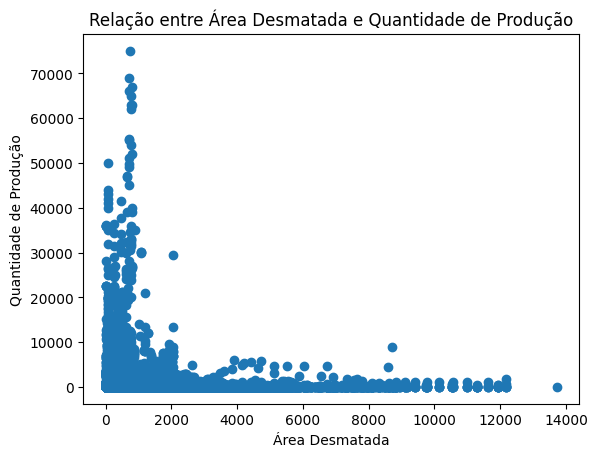

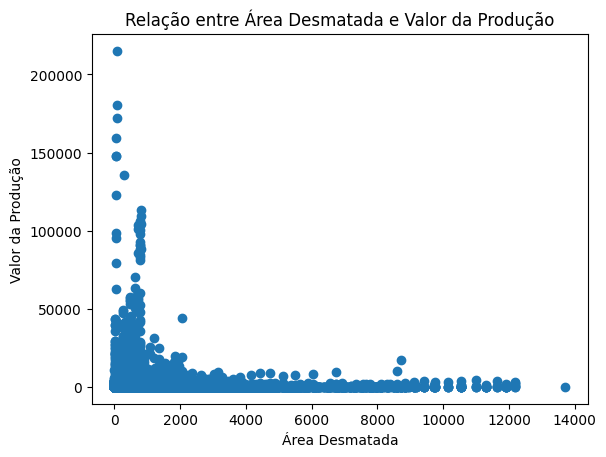

In [ ]:
# Scatter plot entre área desmatada e quantidade de produção
plt.scatter(df_final['desmatado'], df_final['quantidade'])
plt.xlabel('Área Desmatada')
plt.ylabel('Quantidade de Produção')
plt.title('Relação entre Área Desmatada e Quantidade de Produção')
plt.show()

# Scatter plot entre área desmatada e valor da produção
plt.scatter(df_final['desmatado'], df_final['valor'])
plt.xlabel('Área Desmatada')
plt.ylabel('Valor da Produção')
plt.title('Relação entre Área Desmatada e Valor da Produção')
plt.show()


#### Correlação entre as variáveis numéricas

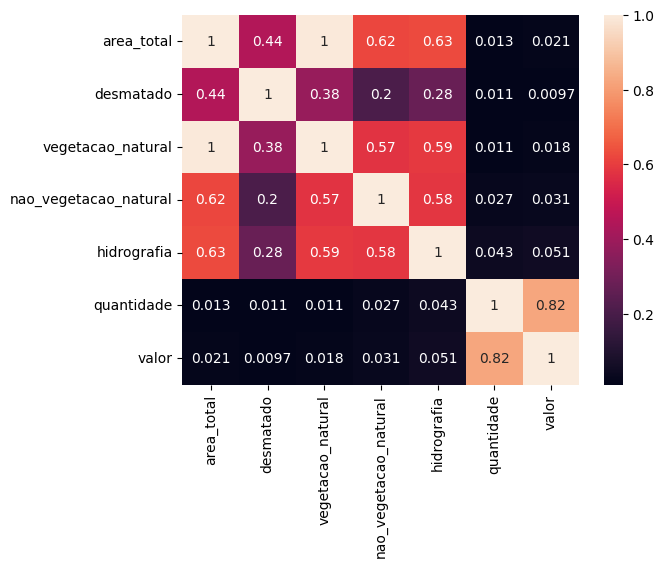

In [ ]:
sns.heatmap(df_final[['area_total', 'desmatado', 'vegetacao_natural', 'nao_vegetacao_natural', 'hidrografia', 'quantidade', 'valor']].corr(), annot=True)
plt.show()

Foi observado que os maiores valores estão relacionados as variáveis que representam áreas, o que é esperado (como área total e área com vegetação natural). Mas no geral, não foi observada aparentes relações entre as variáveis relacionadas ao extrativismo (quantidade e valor da produção) e desmatamento.

#### Análise Temporal

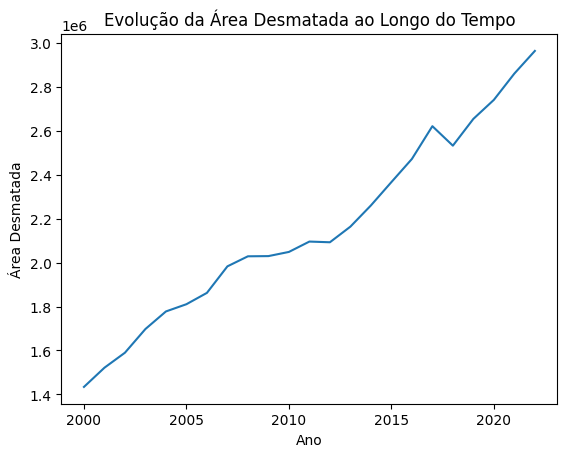

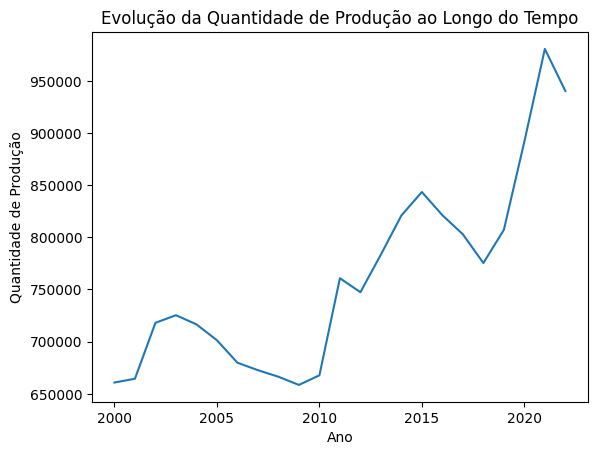

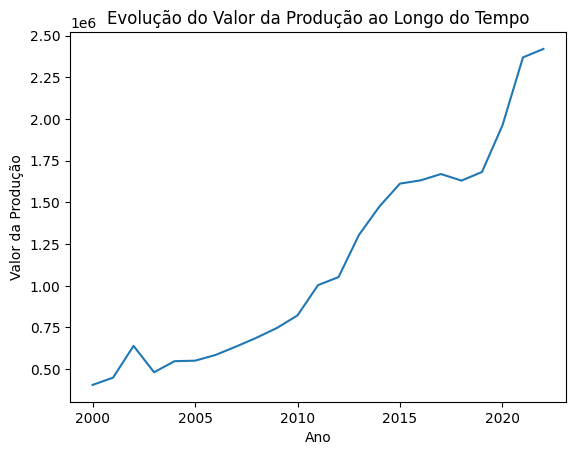

In [ ]:
# Evolução da área desmatada ao longo do tempo
df_final.groupby('ano')['desmatado'].sum().plot()
plt.xlabel('Ano')
plt.ylabel('Área Desmatada')
plt.title('Evolução da Área Desmatada ao Longo do Tempo')
plt.show()

# Evolução da quantidade de produção ao longo do tempo
df_final.groupby('ano')['quantidade'].sum().plot()
plt.xlabel('Ano')
plt.ylabel('Quantidade de Produção')
plt.title('Evolução da Quantidade de Produção ao Longo do Tempo')
plt.show()

# Evolução do valor da produção ao longo do tempo
df_final.groupby('ano')['valor'].sum().plot()
plt.xlabel('Ano')
plt.ylabel('Valor da Produção')
plt.title('Evolução do Valor da Produção ao Longo do Tempo')
plt.show()


Observado uma tendência crescente da área desmatada, da quantidade de produção e do valor da produção no extrativismo ao longo dos anos.

### Desmatamento x Agropecuária

In [ ]:
# Carregar os dados em DataFrames
df_desmatamento = df_d
df_pastagem = df_a1 #df_edb

df_merged = pd.merge(df_desmatamento, df_pastagem, on=['ano', 'id_municipio'], how='left')

# Verificar os tipos de dados
print(df_merged.dtypes)

# Remover linhas com valores nulos nas colunas relevantes
df_final2 = df_merged.dropna(subset=['desmatado', 'valor_producao_total_animal', 'area_pastagem', 'area_pastagem_plantada'])

# Calcular correlações
correlacao_valor = df_final2['desmatado'].astype(float).corr(df_final2['valor_producao_total'].astype(float))
correlacao_pastagem = df_final2['desmatado'].astype(float).corr(df_final2['area_pastagem'].astype(float))
correlacao_pastagem_plantada = df_final2['desmatado'].astype(float).corr(df_final2['area_pastagem_plantada'].astype(float))


print(f"Correlação entre área desmatada e valor de produção total: {correlacao_valor}")
print(f"Correlação entre área desmatada e area de pastagem: {correlacao_pastagem}")
print(f"Correlação entre área desmatada e area de pastagem plantada: {correlacao_pastagem_plantada}")

ano                              Int64
id_municipio                    object
bioma                           object
area_total                       Int64
desmatado                      float64
vegetacao_natural              float64
nao_vegetacao_natural          float64
hidrografia                    float64
area_pastagem_natural          float64
area_pastagem                  float64
area_pastagem_plantada         float64
valor_producao_total           float64
valor_producao_total_animal    float64
dtype: object
Correlação entre área desmatada e valor de produção total: 0.1487565652941453
Correlação entre área desmatada e area de pastagem: 0.5686738908496769
Correlação entre área desmatada e area de pastagem plantada: 0.704216237988776


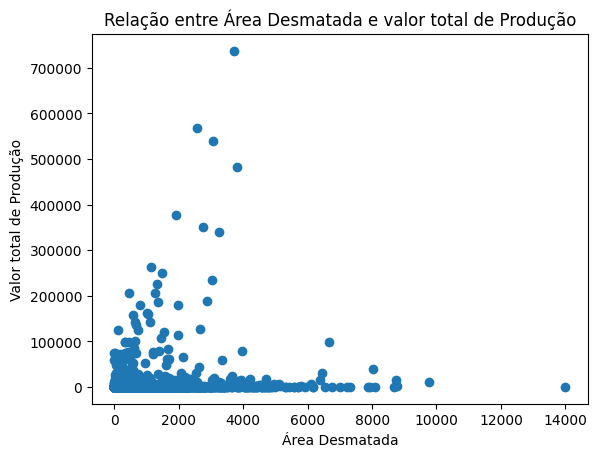

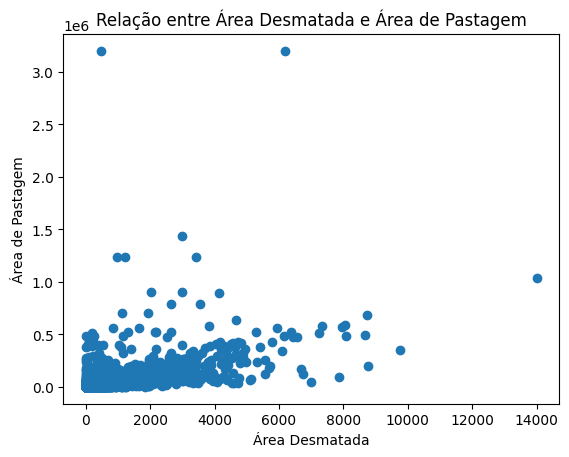

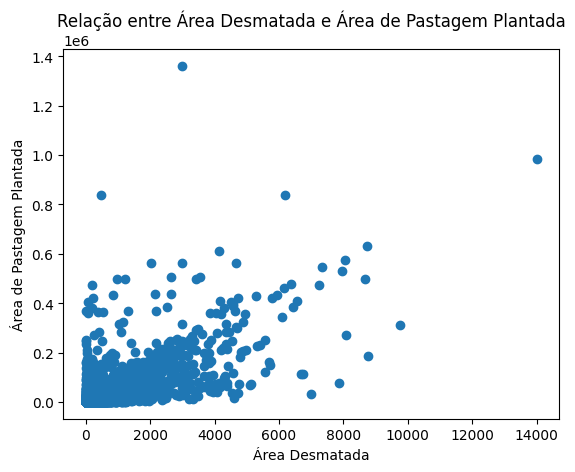

In [ ]:
# Scatter plot entre área desmatada e quantidade de produção
plt.scatter(df_final2['desmatado'], df_final2['valor_producao_total'])
plt.xlabel('Área Desmatada')
plt.ylabel('Valor total de Produção')
plt.title('Relação entre Área Desmatada e valor total de Produção')
plt.show()

# Scatter plot entre área desmatada e valor da produção
plt.scatter(df_final2['desmatado'], df_final2['area_pastagem'])
plt.xlabel('Área Desmatada')
plt.ylabel('Área de Pastagem')
plt.title('Relação entre Área Desmatada e Área de Pastagem')
plt.show()

# Scatter plot entre área desmatada e valor da produção
plt.scatter(df_final2['desmatado'], df_final2['area_pastagem_plantada'])
plt.xlabel('Área Desmatada')
plt.ylabel('Área de Pastagem Plantada')
plt.title('Relação entre Área Desmatada e Área de Pastagem Plantada')
plt.show()


#### Análise Temporal

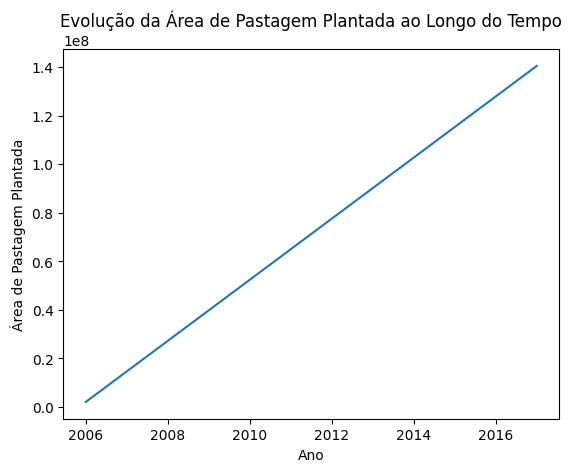

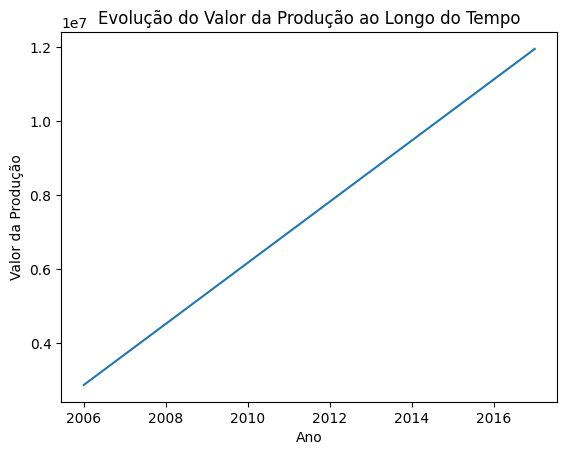

In [ ]:
# Evolução da área de pastagem plantada ao longo do tempo
df_final2.groupby('ano')['area_pastagem_plantada'].sum().plot()
plt.xlabel('Ano')
plt.ylabel('Área de Pastagem Plantada')
plt.title('Evolução da Área de Pastagem Plantada ao Longo do Tempo')
plt.show()

# Evolução do valor da produção ao longo do tempo
df_final2.groupby('ano')['valor_producao_total'].sum().plot()
plt.xlabel('Ano')
plt.ylabel('Valor da Produção')
plt.title('Evolução do Valor da Produção ao Longo do Tempo')
plt.show()


#### Correlação entre as variáveis numéricas

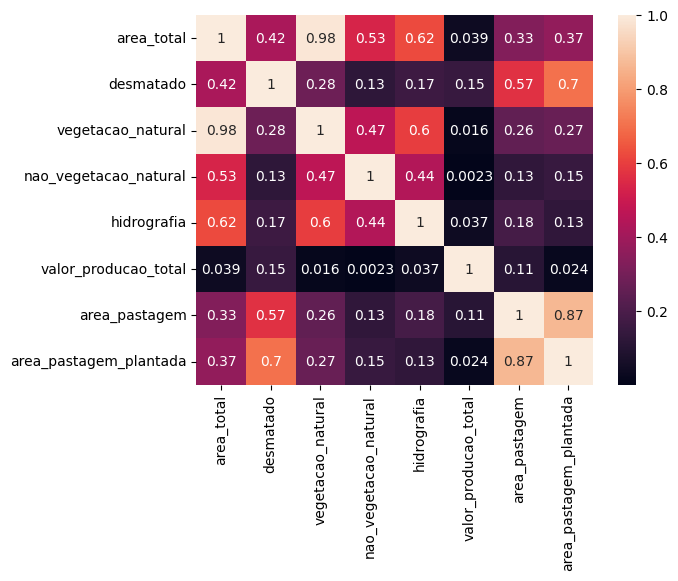

In [ ]:
sns.heatmap(df_final2[['area_total', 'desmatado', 'vegetacao_natural', 'nao_vegetacao_natural', 'hidrografia', 'valor_producao_total', 'area_pastagem', 'area_pastagem_plantada']].corr(), annot=True)
plt.show()

Foi observado que os valores de produção não tem correlação aparente com o desmatamento. No entanto, pode haver uma possível correlação entre a área desmatada e a área de pastagem plantada

## Teste de hipótese

### Extrativismo e Desmatamento

H0: Não há diferença significativa na média da área desmatada entre municípios com extrativismo e municípios sem extrativismo.

In [ ]:
# Dividir dados em duas amostras: com e sem extrativismo
com_extrativismo = df_final[df_final['quantidade'] > 0]['desmatado']
sem_extrativismo = df_final[df_final['quantidade'] == 0]['desmatado']


In [ ]:
com_extrativismo.describe()

count    84611.000000
mean       522.148872
std        878.736837
min          0.000000
25%        106.000000
50%        240.000000
75%        550.600000
max      13717.500000
Name: desmatado, dtype: float64

In [ ]:
sem_extrativismo.describe()

count    10714.000000
mean       507.316716
std        967.366856
min          0.000000
25%         83.150000
50%        208.250000
75%        486.800000
max      11925.200000
Name: desmatado, dtype: float64

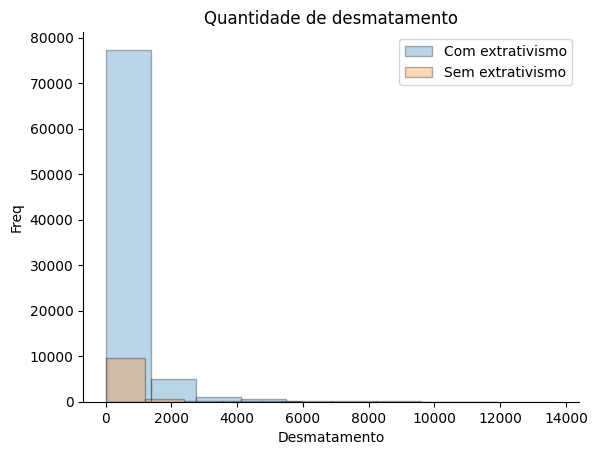

In [ ]:
plt.hist(com_extrativismo, alpha=0.3, edgecolor='k', label='Com extrativismo')
plt.hist(sem_extrativismo, alpha=0.3, edgecolor='k', label='Sem extrativismo')
sns.despine()
plt.title('Quantidade de desmatamento')
plt.xlabel('Desmatamento')
plt.ylabel('Freq')
plt.legend()

Média das Diferenças de Médias: 14.219174507538998
Intervalo de Confiança: [-5.347251549127418, 34.28771494100292]


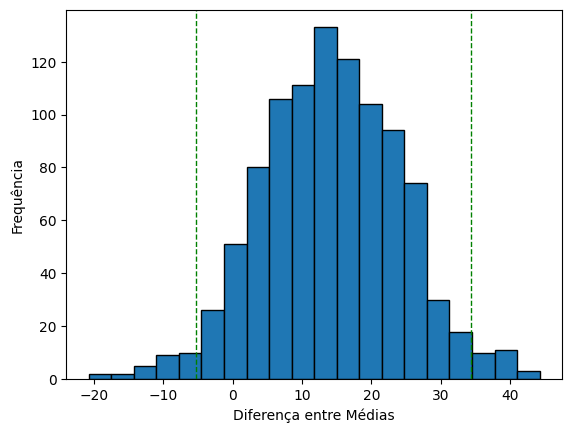

In [ ]:
# TESTE

def bootstrap_mean_diff(group1, group2, num_samples=1000, ci=95):
    mean_diffs = []
    n1, n2 = len(group1), len(group2)
    for _ in range(num_samples):
        sample1 = np.random.choice(group1, n1, replace=True)
        sample2 = np.random.choice(group2, n2, replace=True)
        mean_diffs.append(np.mean(sample1) - np.mean(sample2))
    lower_bound = np.percentile(mean_diffs, (100-ci)/2)
    upper_bound = np.percentile(mean_diffs, 100-(100-ci)/2)
    return mean_diffs, lower_bound, upper_bound


mean_diffs, lower_diff, upper_diff = bootstrap_mean_diff(com_extrativismo, sem_extrativismo)
print(f"Média das Diferenças de Médias: {np.mean(mean_diffs)}")
print(f"Intervalo de Confiança: [{lower_diff}, {upper_diff}]")


plt.hist(mean_diffs, bins=20, edgecolor='black')
plt.ylabel('Frequência')
plt.xlabel('Diferença entre Médias')
plt.axvline(x=lower_diff, color='green', linestyle='--', linewidth=1)
plt.axvline(x=upper_diff, color='green', linestyle='--', linewidth=1)
plt.show()

# TESTE

intervalos de confiança

In [ ]:
# Calcular a média e o desvio padrão dos dados
media_c = com_extrativismo.mean()
std_c = np.std(com_extrativismo, ddof=1)  # ddof=1 para a amostra

media_s = sem_extrativismo.mean()
std_s = np.std(sem_extrativismo, ddof=1)  # ddof=1 para a amostra

# Calcular o erro padrão da média
se_c = std_c / np.sqrt(len(com_extrativismo))
se_s = std_s / np.sqrt(len(sem_extrativismo))

# Calcular os intervalos de confiança com o valor crítico z para um intervalo de confiança de 95%
z = 1.96

ic_c = (media_c - z * se_c, media_c + z * se_c)
ic_s = (media_s - z * se_s, media_s + z * se_s)

print(f"IC com extrativismo: {ic_c}")
print(f"IC sem extrativismo: {ic_s}")


IC com extrativismo: (516.2277842438142, 528.0699595483642)
IC sem extrativismo: (488.9989948509827, 525.634438040561)


In [ ]:
t_stat, p_value = stats.ttest_ind(com_extrativismo, sem_extrativismo, equal_var=False)

print(f"Estatística t: {t_stat}")
print(f"p-value: {p_value}")

# Interpretação do resultado
alpha = 0.05  # Nível de significância
if p_value < alpha:
    print("Rejeita a hipótese nula, há diferença significativa nas médias.")
else:
    print("Não rejeita a hipótese nula, não há diferença significativa nas médias.")


Estatística t: 1.5101103531661955
p-value: 0.13103947798903345
Não rejeita a hipótese nula, não há diferença significativa nas médias.


## Regressão

##### Codigo da Regressão

In [ ]:
def regressaoLinear(dep, indep, df, title):
    # Convertendo colunas para float64, se necessário
    df[dep] = df[dep].astype(float)
    df[indep] = df[indep].astype(float)

    X = df[[dep]].values  # Usando [[]] para manter X como uma matriz
    y = df[indep].values  # y já está em uma matriz

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    lin_regr = linear_model.LinearRegression()
    lin_regr.fit(X_train, y_train)

    y_pred = lin_regr.predict(X_test)

    print(f'Coefficient: {lin_regr.coef_[0]:.2f}')
    print(f'Intercept: {lin_regr.intercept_:.2f}')
    print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}')
    print(f'R2: {r2_score(y_test, y_pred):.2f}')

    # Plotando regressão usando seaborn
    sns.regplot(x=dep, y=indep, data=df, line_kws={'color': 'red'})
    plt.title(f'Regressão linear, {title}')
    plt.show()

##### Codigo do Bootstrap

In [ ]:
def bootstrap_regression_and_plot(dep, indep, df, n_bootstrap=1000):
    """
    Realiza o bootstrap para uma regressão linear, plota histogramas dos coeficientes e interceptos, e ajusta a regressão para cada amostra.

    Parameters:
    - dep: Nome da coluna dependente (variável resposta).
    - indep: Nome da coluna independente (variável explicativa).
    - df: DataFrame contendo os dados.
    - n_bootstrap: Número de amostras de bootstrap (default é 1000).
    """
    # Convertendo colunas para float64, se necessário
    df[dep] = df[dep].astype(float)
    df[indep] = df[indep].astype(float)

    X = df[[dep]].values  # Usando [[]] para manter X como uma matriz
    y = df[indep].values  # y já está em uma matriz

    coefs = []
    intercepts = []

    for _ in range(n_bootstrap):
        # Amostragem com reposição
        indices = np.random.choice(len(X), len(X), replace=True)
        X_bootstrap = X[indices]
        y_bootstrap = y[indices]

        # Dividindo em treino e teste
        X_train, X_test, y_train, y_test = train_test_split(X_bootstrap, y_bootstrap, test_size=0.2)

        # Ajustando o modelo
        lin_regr = linear_model.LinearRegression()
        lin_regr.fit(X_train, y_train)

        # Salvando coeficientes e interceptos
        coefs.append(lin_regr.coef_[0])
        intercepts.append(lin_regr.intercept_)

    # Plotando histogramas dos coeficientes e interceptos
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(coefs, kde=True)
    plt.title('Distribuição dos Coeficientes')
    plt.xlabel('Coeficiente')
    plt.ylabel('Frequência')

    plt.subplot(1, 2, 2)
    sns.histplot(intercepts, kde=True)
    plt.title('Distribuição dos Interceptos')
    plt.xlabel('Intercepto')
    plt.ylabel('Frequência')

    plt.tight_layout()
    plt.show()

In [ ]:


def bootstrap_r2(dep, indep, df, n_bootstrap=1000, test_size=0.2):
    """
    Realiza o bootstrap para estimar o intervalo de confiança do R2 da regressão linear.

    Parameters:
    - dep: Nome da coluna dependente (variável resposta).
    - indep: Nome da coluna independente (variável explicativa).
    - df: DataFrame contendo os dados.
    - n_bootstrap: Número de amostras de bootstrap (default é 1000).
    - test_size: Proporção dos dados utilizados para teste (default é 0.2).

    Returns:
    - Intervalo de confiança do R2.
    """
    # Convertendo colunas para float64, se necessário
    df[dep] = df[dep].astype(float)
    df[indep] = df[indep].astype(float)

    X = df[[dep]].values  # Usando [[]] para manter X como uma matriz
    y = df[indep].values  # y já está em uma matriz

    r2_scores = []

    for _ in range(n_bootstrap):
        # Amostragem com reposição
        indices = np.random.choice(len(X), len(X), replace=True)
        X_bootstrap = X[indices]
        y_bootstrap = y[indices]

        # Dividindo em treino e teste
        X_train, X_test, y_train, y_test = train_test_split(X_bootstrap, y_bootstrap, test_size=test_size)

        # Ajustando o modelo
        lin_regr = linear_model.LinearRegression()
        lin_regr.fit(X_train, y_train)

        # Calculando o R2
        y_pred = lin_regr.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred))

    # Calculando o intervalo de confiança de 95%
    lower_bound = np.percentile(r2_scores, 2.5)
    upper_bound = np.percentile(r2_scores, 97.5)

    print(f'Intervalo de Confiança do R2 (95%): ({lower_bound:.3f}, {upper_bound:.3f})')

    # Plotando o histograma dos R2
    plt.figure(figsize=(8, 6))
    sns.histplot(r2_scores, kde=True)
    plt.title('Distribuição dos R2 do Bootstrap')
    plt.xlabel('R2')
    plt.ylabel('Frequência')
    plt.show()

#### Desmatamento x Produção no extrativismo (toneladas)

##### Regressão Linear

Coefficient: 0.01
Intercept: 519.91
Mean squared error: 775043.00
R2: 0.00


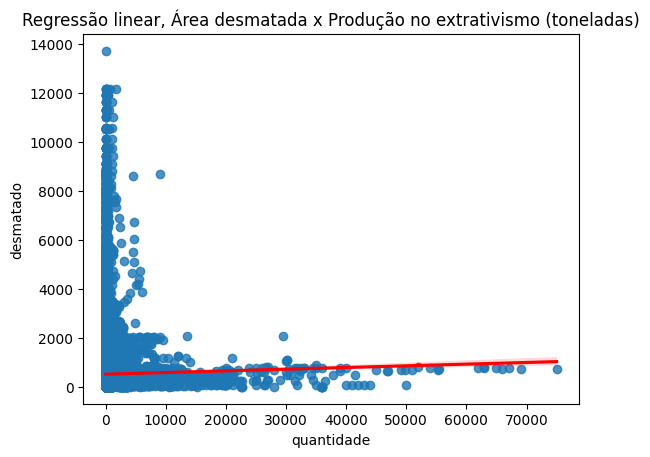

In [ ]:
regressaoLinear('quantidade', 'desmatado', df_final,  'Área desmatada x Produção no extrativismo (toneladas)')

A regressão linear simples falhou.

##### Bootstrap e Intervalo de Confiança nos R2 da regressão linear

Intervalo de Confiança do R2 (95%): (-0.000, 0.000)


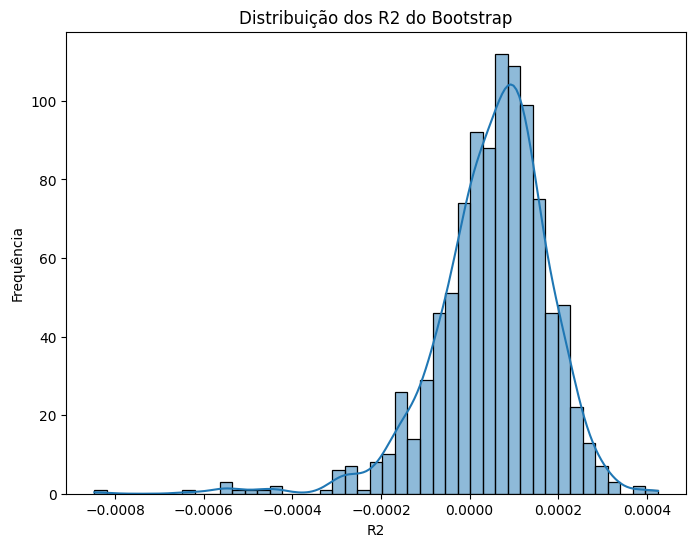

In [ ]:
bootstrap_r2('quantidade', 'desmatado', df_final)

#### Desmatamento x Agropecuária

In [ ]:
dep = 'area_pastagem_plantada'
indep = 'desmatado'

Coefficient: 0.01
Intercept: 256.57
Mean squared error: 290702.39
R2: 0.58


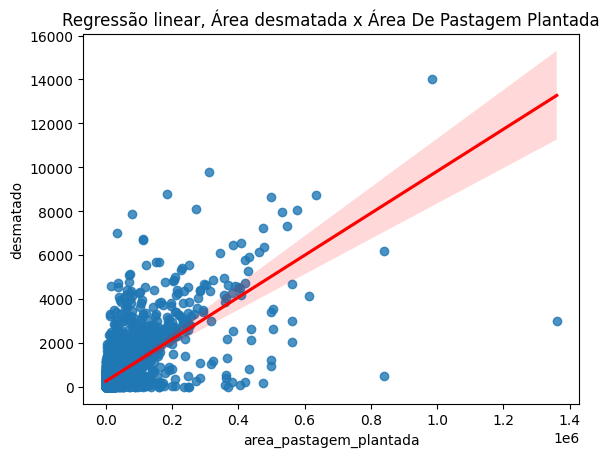

In [ ]:
regressaoLinear(dep, indep, df_final2, 'Área desmatada x Área De Pastagem Plantada')

Os resultados da regressão linear entre a área desmatada e as variáveis de agropecuária, com um coeficiente de 0.58, indicam uma correlação moderada.

##### Bootstrap nos coeficientes e nos interceptos

In [ ]:
df = df_final2

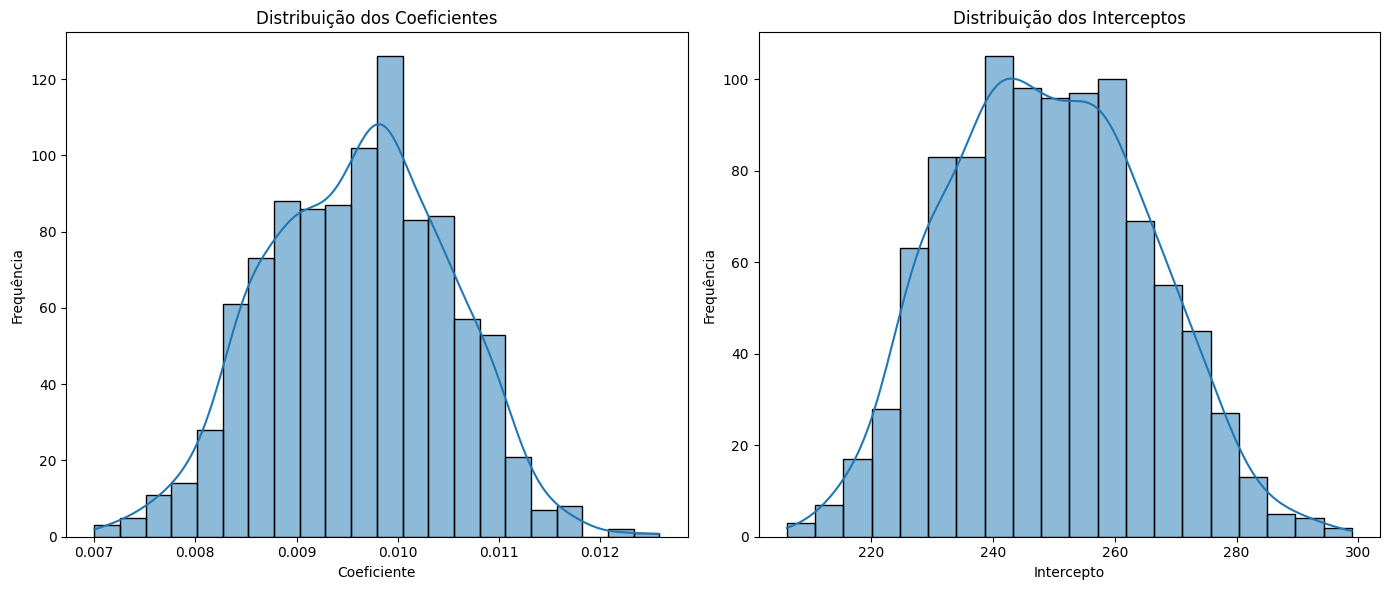

In [ ]:
bootstrap_regression_and_plot(dep, indep, df)

#### Bootstrap e Intervalo de Confiança nos R2 da regressão linear

Intervalo de Confiança do R2 (95%): (0.251, 0.652)


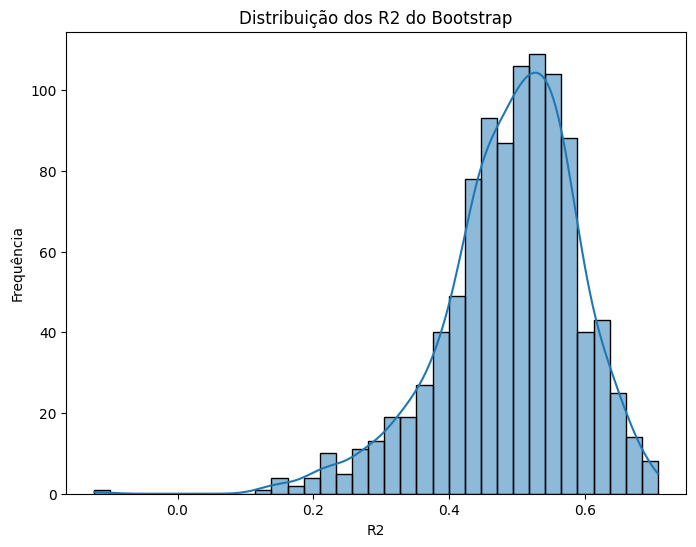

In [ ]:
bootstrap_r2(dep, indep, df)

## Conclusões
Com base nos resultados obtidos, podemos concluir que:

Agropecuária: As análises de regressão linear entre a área desmatada e as variáveis de agropecuária revelaram uma correlação moderada, com um coeficiente de 0,58. Após aplicar o método de bootstrap, a faixa de confiança foi determinada entre 0,5 e 0,6. Embora a expectativa fosse de uma correlação mais forte, esses resultados ainda são significativos. Eles indicam que, embora exista uma relação entre as atividades agropecuárias e o desmatamento, outros fatores também podem estar influenciando o desmatamento. Esses fatores podem incluir políticas ambientais, práticas de manejo sustentável, variações climáticas, entre outros.

Extrativismo: As análises de regressão linear entre a área desmatada e a quantidade de produção de extrativismo não apresentaram resultados significativos. Isso indica que não há uma correlação clara entre essas variáveis (pelo menos não com esse conjunto de dados), sugerindo que o desmatamento pode não estar diretamente relacionado às atividades de extrativismo.

#Relatório - Análise da Relação entre Posse Ilegal de Arma de Fogo e Feminícidios no Brasil

Autor: Eduardo Alves Cordeiro

##Introdução
A violência contra a mulher, especialmente na forma de feminicídio, é um grave problema social que afeta inúmeras vidas no Brasil. Nos últimos anos, o debate sobre a posse e porte de armas de fogo tem se intensificado, com mudanças na legislação e políticas públicas que impactam diretamente a sociedade. Diante deste cenário, surge a necessidade de investigar se o aumento da posse e porte de armas está relacionado ao crescimento dos índices de feminicídio e violência contra a mulher.

**Pergunta: O aumento da posse e porte de armas está relacionado ao crescimento dos índices de feminicídio e violência contra a mulher?**



##Metodologia

**Bases de Dados Utilizadas**

Para conduzir esta análise, foram utilizadas duas bases de dados essenciais, ambas fornecidas pela plataforma BaseDados.


*   Base de Dados de Segurança Pública (FBSP/ABSP): Esta base de dados, compilada pelo Fórum Brasileiro de Segurança Pública (FBSP) e pela Associação Brasileira de Segurança Pública (ABSP), contém informações detalhadas sobre crimes e ocorrências policiais em todo o território nacional. Ela inclui registros de feminicídios, violência doméstica, e outros tipos de violência contra a mulher, permitindo uma análise aprofundada dos padrões criminais e suas variações ao longo do tempo.
*   Base de Dados de População (IBGE): Os dados populacionais foram extraídos da base do Instituto Brasileiro de Geografia e Estatística (IBGE). Esta base é crucial para contextualizar os dados de violência em relação ao tamanho e composição da população, permitindo o cálculo de taxas e proporções que facilitam comparações significativas e a identificação de tendências.





## Métodos e Modelos

Para conduzir a análise dos dados, foi realizado um processo cuidadoso de preparação e modelagem.

**Limpeza de Dados:**



*   Remoção de Variáveis Irrelevantes: Para garantir que apenas as variáveis mais
pertinentes fossem incluídas na análise, foi realizada a remoção de variáveis que não contribuíam significativamente para os objetivos do estudo.
*   Tratamento de Valores Ausentes: Valores ausentes foram identificados e tratados adequadamente para evitar vieses e garantir a integridade dos dados.



**Análise Exploratória de Dados:**


*   Verificação de Correlações: Foram examinadas as correlações entre as variáveis para identificar relações significativas que pudessem impactar a análise
*   Criação de Histogramas e Distribuições: Histogramas foram gerados para visualizar a distribuição das variáveis e foram criadas distribuições para a quantidade de feminicídios e posse/porte de armas ilegais, permitindo uma análise mais detalhada do fenômeno.

**Modelo e Métrica de Avaliação:**


*   Regressão Linear: Após a preparação dos dados, foram aplicados modelos de regressão linear para examinar a relação entre a posse e porte de armas e os índices de feminicídio e violência contra a mulher.
*   Métricas de Avaliação: As métricas utilizadas para avaliar os modelos foram o Erro Quadrático Médio (MSE), que avalia a precisão das previsões, e o Coeficiente de Determinação (R²), que mede a proporção da variabilidade explicada pelo modelo.





##*Conclusão*

Os resultados da análise indicaram que a correlação entre a quantidade de feminicídios e a violência doméstica foi relativamente alta (0,77), enquanto a correlação entre a quantidade de feminicídios e a posse/porte de arma ilegal foi moderada (0,49). No entanto, a regressão linear entre a quantidade de feminicídios e a posse ilegal de armas apresentou um coeficiente de determinação (R²) de apenas 0,0134, sugerindo que a posse ilegal de armas explica muito pouco da variação nos casos de feminicídio. Além disso, o Erro Quadrático Médio (MSE) médio foi de 0,1480, com um intervalo de confiança de 95% entre 0,1448 e 0,1568, indicando uma variabilidade considerável nos erros de previsão. Esses resultados foram insatisfatórios, principalmente devido à limitação das bases de dados utilizadas, que continham um número reduzido de dados, o que pode ter comprometido a robustez das análises e a confiabilidade das conclusões.

##Código


##Carregamento dos dados:

In [ ]:
import pandas as pd
!pip install basedosdados
import basedosdados as bd

# Para carregar o dado direto no pandas
fem = bd.read_table(dataset_id='br_fbsp_absp',
table_id='municipio',
billing_project_id="direct-topic-426918-u6")

pop = bd.read_table(dataset_id='br_ibge_populacao',
table_id='municipio',
billing_project_id="direct-topic-426918-u6")


Downloading: 100%|██████████| 174388/174388 [00:07<00:00, 22220.52rows/s]


##Limpeza dos dados:

In [ ]:
colunas_desejadas_fem = ['ano', 'quantidade_feminicidio', 'quantidade_lesao_corporal_dolosa_violencia_domestica',
                     'sigla_uf', 'id_municipio','quantidade_posse_ilegal_porte_ilegal_arma_de_fogo']

df_fem = fem[colunas_desejadas_fem]
df_fem = df_fem.dropna()
df= pd.merge(df_fem, pop, on=['ano', 'sigla_uf', 'id_municipio'], how='inner')

df = df.groupby(['ano', 'sigla_uf']).agg({
    'quantidade_feminicidio': 'sum',
    'quantidade_lesao_corporal_dolosa_violencia_domestica': 'sum',
    'quantidade_posse_ilegal_porte_ilegal_arma_de_fogo': 'sum',
    'populacao': 'sum'
}).reset_index()




In [ ]:
df['Taxa_Feminicidio_por_100k'] = (df['quantidade_feminicidio'] / df['populacao']) * 100000
df['Taxa_Lesao_corporal_dolosa_por_100k'] = (df['quantidade_lesao_corporal_dolosa_violencia_domestica'] / df['populacao']) * 100000
df['Proporcao_Posse_Porte_ilegal_arma_por_100k'] = (df['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo'] / df['populacao']) * 100000


In [ ]:
df.info() #para obter informações do dataframe
df.describe() #para ver um descrição mais detalhada

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 9 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   ano                                                   89 non-null     Int64  
 1   sigla_uf                                              89 non-null     object 
 2   quantidade_feminicidio                                89 non-null     Int64  
 3   quantidade_lesao_corporal_dolosa_violencia_domestica  89 non-null     Int64  
 4   quantidade_posse_ilegal_porte_ilegal_arma_de_fogo     89 non-null     Int64  
 5   populacao                                             89 non-null     Int64  
 6   Taxa_Feminicidio_por_100k                             89 non-null     Float64
 7   Taxa_Lesao_corporal_dolosa_por_100k                   89 non-null     Float64
 8   Proporcao_Posse_Porte_ilegal_arma_por_100k            89 non-nu

,ano,quantidade_feminicidio,quantidade_lesao_corporal_dolosa_violencia_domestica,quantidade_posse_ilegal_porte_ilegal_arma_de_fogo,populacao,Taxa_Feminicidio_por_100k,Taxa_Lesao_corporal_dolosa_por_100k,Proporcao_Posse_Porte_ilegal_arma_por_100k
count,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0
mean,2019.640449,9.044944,2337.382022,402.932584,2005480.752809,0.591127,122.648056,27.137457
std,1.068635,8.725498,3032.768355,408.930223,2582635.717867,0.383503,78.041696,24.212984
min,2018.0,0.0,78.0,25.0,299127.0,0.0,2.885265,2.104385
25%,2019.0,4.0,628.0,144.0,648939.0,0.312551,76.292351,12.18949
50%,2020.0,6.0,1278.0,312.0,1108975.0,0.549762,107.228813,23.443286
75%,2021.0,11.0,2442.0,523.0,2255903.0,0.743368,163.614802,33.327689
max,2021.0,44.0,15368.0,2978.0,12396372.0,2.233931,516.623004,200.704826


In [ ]:
duplicados = fem[fem.duplicated(keep='first')]#Para visualizar se tem dados duplicados
print(duplicados)

Empty DataFrame
Columns: [ano, sigla_uf, id_municipio, grupo, quantidade_homicidio_doloso, quantidade_latrocinio, quantidade_lesao_corporal_morte, quantidade_mortes_policiais_confronto, quantidade_mortes_intervencao_policial, quantidade_mortes_intervencao_policial_civil_em_servico, quantidade_mortes_intervencao_policial_militar_em_servico, quantidade_mortes_intervencao_policial_civil_fora_de_servico, quantidade_mortes_intervencao_policial_militar_fora_de_servico, quantidade_mortes_violentas_intencionais, quantidade_feminicidio, quantidade_lesao_corporal_dolosa_violencia_domestica, quantidade_estupro, quantidade_roubo_veiculos, quantidade_furto_veiculos, quantidade_roubo_furto_veiculos, proporcao_mortes_intenvencao_policial_x_mortes_violentas_intencionais, quantidade_posse_ilegal_arma_de_fogo, quantidade_porte_ilegal_arma_de_fogo, quantidade_posse_ilegal_porte_ilegal_arma_de_fogo, quantidade_trafico_entorpecente, quantidade_posse_uso_entorpecente, quantidade_morte_policiais_civis_confro

##Análise Exploratória de Dados

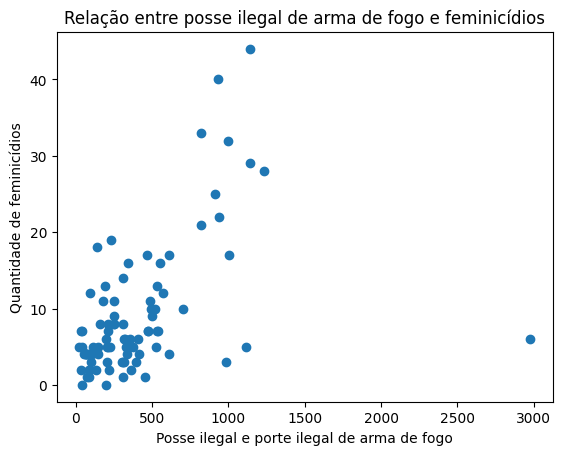

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo'], df['quantidade_feminicidio'])
plt.xlabel('Posse ilegal e porte ilegal de arma de fogo')
plt.ylabel('Quantidade de feminicídios')
plt.title('Relação entre posse ilegal de arma de fogo e feminicídios')
plt.show()


Interpretação do gráfico posse ilegal de arma de fogo e feminicidio:
Há uma dispersão significativa à medida que a posse ilegal de armas aumenta, o que pode indicar uma tendência de aumento na quantidade de feminicídios conforme o número de posse ilegal de armas também aumenta.

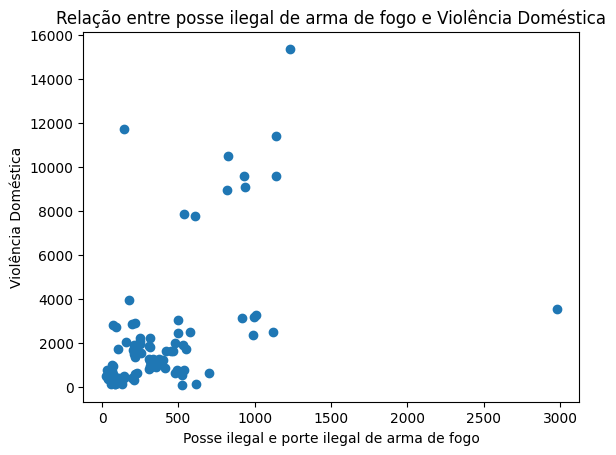

In [ ]:
plt.scatter(df['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo'], df['quantidade_lesao_corporal_dolosa_violencia_domestica'])
plt.xlabel('Posse ilegal e porte ilegal de arma de fogo')
plt.ylabel('Violência Doméstica')
plt.title('Relação entre posse ilegal de arma de fogo e Violência Doméstica')
plt.show()

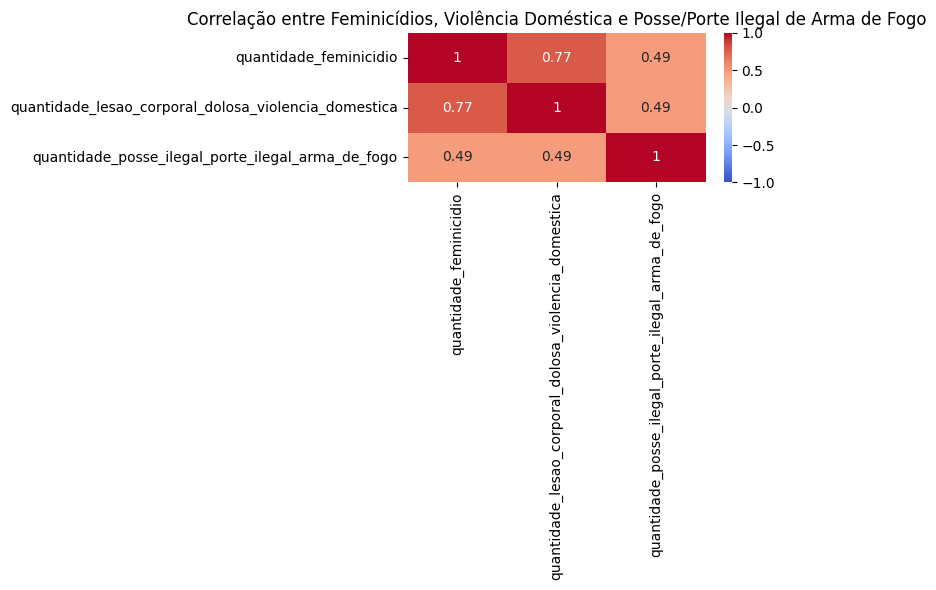

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlacoes = df[['quantidade_feminicidio', 'quantidade_lesao_corporal_dolosa_violencia_domestica',
                  'quantidade_posse_ilegal_porte_ilegal_arma_de_fogo']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlacoes, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlação entre Feminicídios, Violência Doméstica e Posse/Porte Ilegal de Arma de Fogo')
plt.tight_layout()
plt.show()




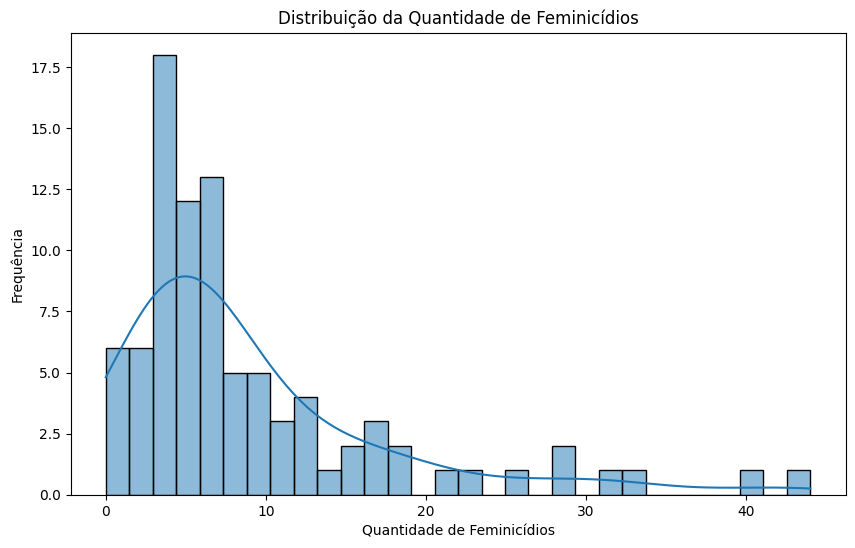

In [ ]:
# Histograma da quantidade de feminicídios
plt.figure(figsize=(10, 6))
sns.histplot(df['quantidade_feminicidio'], bins=30, kde=True)
plt.title('Distribuição da Quantidade de Feminicídios')
plt.xlabel('Quantidade de Feminicídios')
plt.ylabel('Frequência')
plt.show()

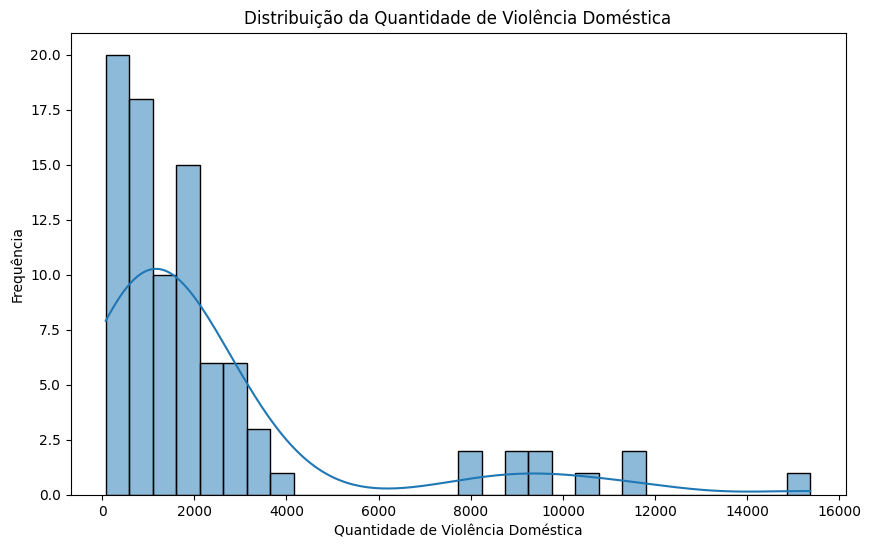

In [ ]:
# Histograma da quantidade de violência doméstica
plt.figure(figsize=(10, 6))
sns.histplot(df['quantidade_lesao_corporal_dolosa_violencia_domestica'], bins=30, kde=True)
plt.title('Distribuição da Quantidade de Violência Doméstica')
plt.xlabel('Quantidade de Violência Doméstica')
plt.ylabel('Frequência')
plt.show()

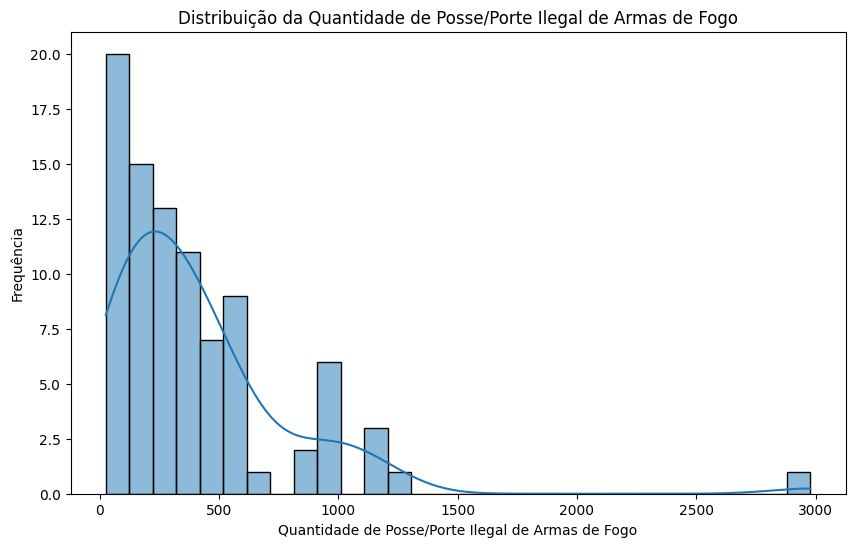

In [ ]:
# Histograma da quantidade de posse/porte ilegal de armas de fogo
plt.figure(figsize=(10, 6))
sns.histplot(df['quantidade_posse_ilegal_porte_ilegal_arma_de_fogo'], bins=30, kde=True)
plt.title('Distribuição da Quantidade de Posse/Porte Ilegal de Armas de Fogo')
plt.xlabel('Quantidade de Posse/Porte Ilegal de Armas de Fogo')
plt.ylabel('Frequência')
plt.show()

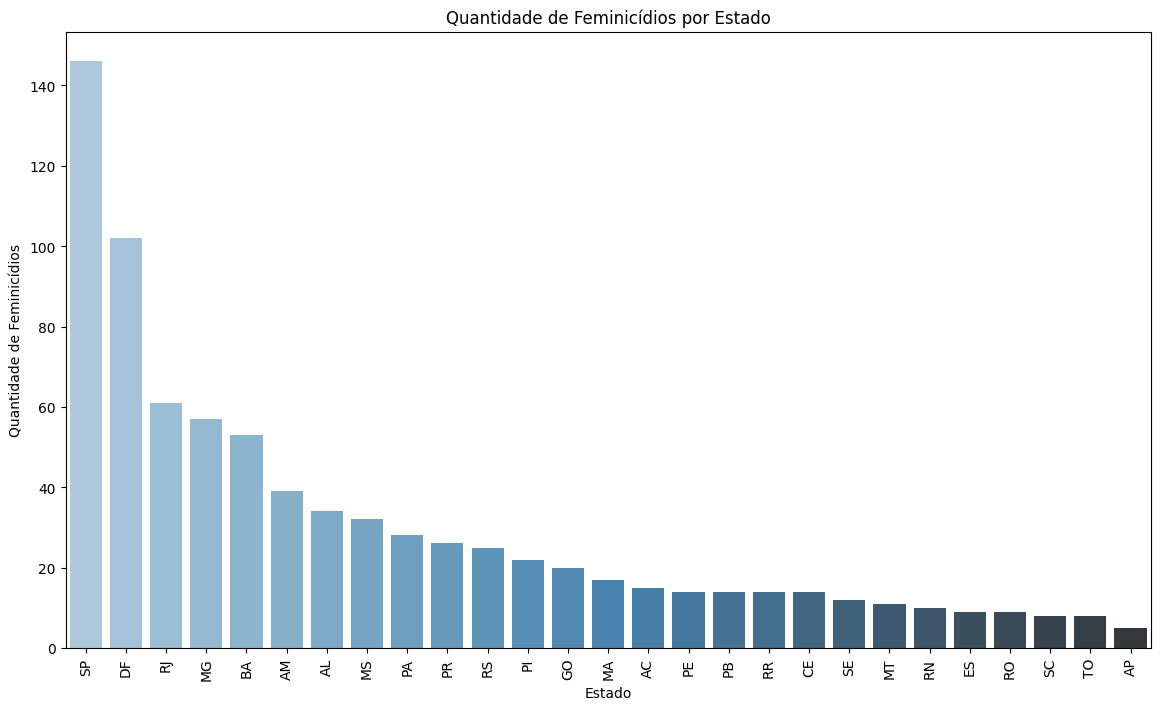

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agregando dados por estado
df_estado = df.groupby('sigla_uf').agg({
    'quantidade_feminicidio': 'sum',
    'quantidade_posse_ilegal_porte_ilegal_arma_de_fogo': 'sum'
}).reset_index()

# Ordenando os dados
df_estado = df_estado.sort_values(by='quantidade_feminicidio', ascending=False)

# Plotando o gráfico de feminicídios
plt.figure(figsize=(14, 8))
sns.barplot(x='sigla_uf', y='quantidade_feminicidio', data=df_estado, palette='Blues_d')
plt.xlabel('Estado')
plt.ylabel('Quantidade de Feminicídios')
plt.title('Quantidade de Feminicídios por Estado')
plt.xticks(rotation=90)
plt.show()


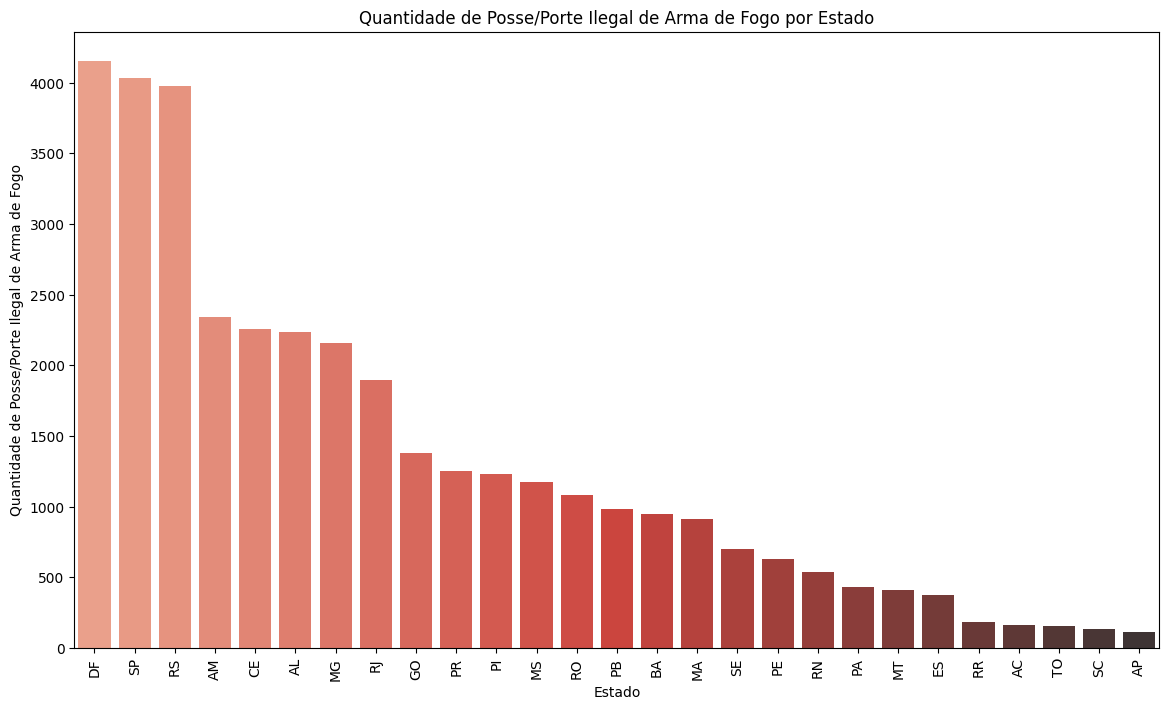

In [ ]:
# Ordenando os dados
df_estado = df_estado.sort_values(by='quantidade_posse_ilegal_porte_ilegal_arma_de_fogo', ascending=False)

# Plotando o gráfico de posse/porte ilegal de arma de fogo
plt.figure(figsize=(14, 8))
sns.barplot(x='sigla_uf', y='quantidade_posse_ilegal_porte_ilegal_arma_de_fogo', data=df_estado, palette='Reds_d')
plt.xlabel('Estado')
plt.ylabel('Quantidade de Posse/Porte Ilegal de Arma de Fogo')
plt.title('Quantidade de Posse/Porte Ilegal de Arma de Fogo por Estado')
plt.xticks(rotation=90)
plt.show()


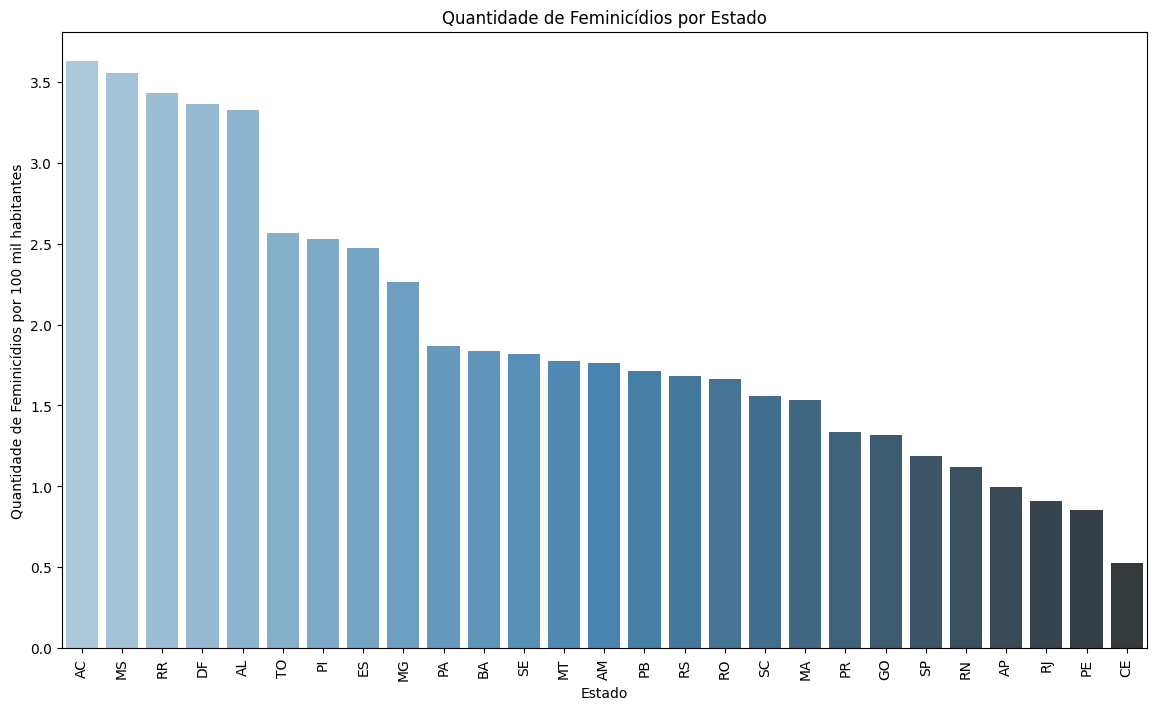

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agregando dados por estado
df_estado = df.groupby('sigla_uf').agg({
    'Taxa_Feminicidio_por_100k': 'sum',
    'Proporcao_Posse_Porte_ilegal_arma_por_100k': 'sum'
}).reset_index()

# Ordenando os dados
df_estado = df_estado.sort_values(by='Taxa_Feminicidio_por_100k', ascending=False)

# Plotando o gráfico de feminicídios
plt.figure(figsize=(14, 8))
sns.barplot(x='sigla_uf', y='Taxa_Feminicidio_por_100k', data=df_estado, palette='Blues_d')
plt.xlabel('Estado')
plt.ylabel('Quantidade de Feminicídios por 100 mil habitantes')
plt.title('Quantidade de Feminicídios por Estado')
plt.xticks(rotation=90)
plt.show()


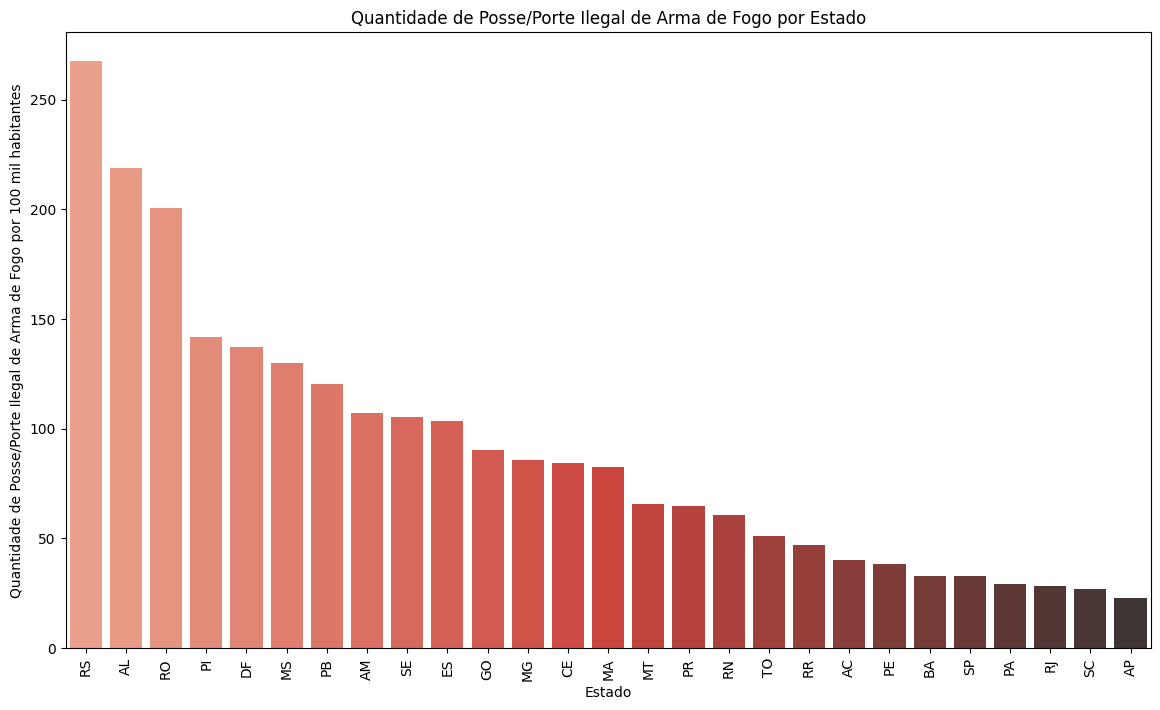

In [ ]:

# Ordenando os dados
df_estado = df_estado.sort_values(by='Proporcao_Posse_Porte_ilegal_arma_por_100k', ascending=False)

# Plotando o gráfico de posse/porte ilegal de arma de fogo
plt.figure(figsize=(14, 8))
sns.barplot(x='sigla_uf', y='Proporcao_Posse_Porte_ilegal_arma_por_100k', data=df_estado, palette='Reds_d')
plt.xlabel('Estado')
plt.ylabel('Quantidade de Posse/Porte Ilegal de Arma de Fogo por 100 mil habitantes')
plt.title('Quantidade de Posse/Porte Ilegal de Arma de Fogo por Estado')
plt.xticks(rotation=90)
plt.show()



##Regressão Linear

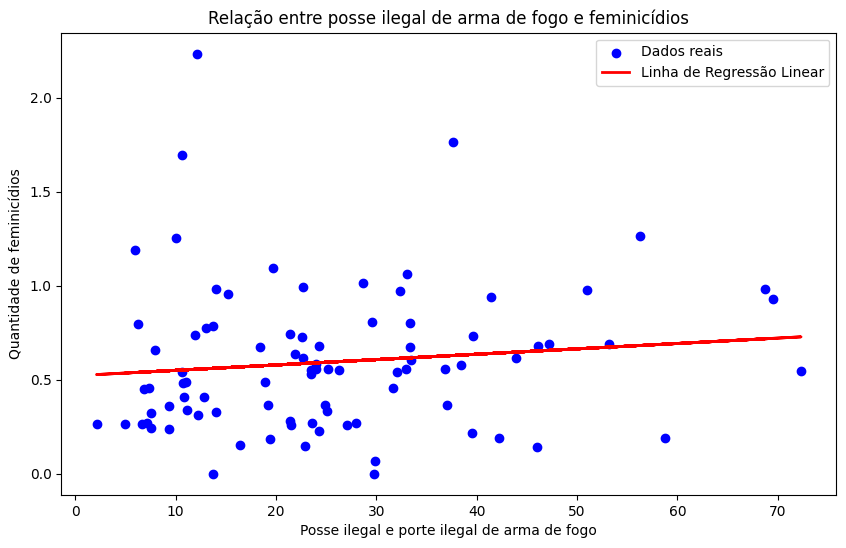

Coeficiente de determinação R^2: 0.0134


In [ ]:
df = df[df['Proporcao_Posse_Porte_ilegal_arma_por_100k'] <= 100]
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Definindo as variáveis independentes e dependentes
X = df['Proporcao_Posse_Porte_ilegal_arma_por_100k'].values.reshape(-1, 1)
y = df['Taxa_Feminicidio_por_100k'].values

# Criando o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Fazendo previsões
y_pred = modelo.predict(X)

# Plotando os dados e a linha de regressão
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Dados reais')
plt.plot(X, y_pred, color='red', linewidth=2, label='Linha de Regressão Linear')
plt.xlabel('Posse ilegal e porte ilegal de arma de fogo')
plt.ylabel('Quantidade de feminicídios')
plt.title('Relação entre posse ilegal de arma de fogo e feminicídios')
plt.legend()
plt.show()

# Coeficiente de determinação R^2
r2 = modelo.score(X, y)
print(f'Coeficiente de determinação R^2: {r2:.4f}')


In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

# Função para calcular o MSE com reamostragem bootstrap
def bootstrap_mse(X, y, modelo, n_iterations=1000, alpha=0.05):
    bootstrapped_mse = []

    # Realiza reamostragem e calcula o MSE para cada iteração
    for i in range(n_iterations):
        X_resampled, y_resampled = resample(X, y)
        modelo.fit(X_resampled, y_resampled)
        y_pred = modelo.predict(X)
        mse = mean_squared_error(y, y_pred)
        bootstrapped_mse.append(mse)

    # Calcula os percentis para os intervalos de confiança
    lower_percentile = np.percentile(bootstrapped_mse, 100 * alpha / 2)
    upper_percentile = np.percentile(bootstrapped_mse, 100 * (1 - alpha / 2))

    return np.mean(bootstrapped_mse), lower_percentile, upper_percentile

# Calculando o MSE e seus intervalos de confiança
mean_mse, lower_ic, upper_ic = bootstrap_mse(X, y, modelo)

print(f'MSE médio: {mean_mse:.4f}')
print(f'Intervalo de Confiança de 95% para o MSE: ({lower_ic:.4f}, {upper_ic:.4f})')


MSE médio: 0.1480
Intervalo de Confiança de 95% para o MSE: (0.1448, 0.1568)
